# Evaluation metrics calculation

Baselines: BM25, embedding-based classifiers.
Evaluation metrics:

- ID vs Non-ID: AUROC/AUPRC, FPR@TPR95
- ID labels: F1 score


## WITSML labels preparation


Load the files containing the true labels and predictions:


In [1]:
from pathlib import Path
import json
import sys

current_dir = Path().resolve()
project_root = current_dir.parent

sys.path.append(str(project_root))

import server.utils.quality_assurance.quality_gate as qg  # noqa

true_labels_files = [
    project_root / "data_store/test_data/new_labels/extracted_json/9-F-9_A+1+log+1+1+1+00001.json",
    project_root / "data_store/test_data/new_labels/extracted_json/9-F-9_A+1+log+2+1+1+00001.json",
    project_root / "data_store/test_data/new_labels/extracted_json/9-F-9_A+1+log+2+2+1+00001.json",
]

predictions_files_BM25 = [
    project_root / "notebooks/BM25/recognition_results_1.json",
    project_root / "notebooks/BM25/recognition_results_2.json",
    project_root / "notebooks/BM25/recognition_results_3.json",
]

predictions_files_embedding = [
    project_root / "notebooks/Embedding/recognition_results_1.json",
    project_root / "notebooks/Embedding/recognition_results_2.json",
    project_root / "notebooks/Embedding/recognition_results_3.json",
]

predictions_files_logprob = [
    project_root / "notebooks/logprob/9f9a_111_20251005/task_batch.json",
    project_root / "notebooks/logprob/9f9a_211_20251005/task_batch.json",
    project_root / "notebooks/logprob/9f9a_221_20251005/task_batch.json",
]

predictions_files_simpleRAG = [
    project_root / "notebooks/simpleRAG/9f9a_111_202505/task_batch.json",
    project_root / "notebooks/simpleRAG/9f9a_211_202505/task_batch.json",
    project_root / "notebooks/simpleRAG/9f9a_221_202505/task_batch.json",
]

true_label_objs = []
for i in range(len(true_labels_files)):
    with open(true_labels_files[i], "r", encoding="utf-8") as f:
        data = json.load(f)
        query_tmp = {}
        for j in range(len(data)):
            mnemonic = data[j]["Mnemonic"]
            query_tmp.update({mnemonic: data[j]})
        true_label_objs.append(query_tmp)

predictions_BM25_objs = []
for i in range(len(predictions_files_BM25)):
    with open(predictions_files_BM25[i], "r", encoding="utf-8") as f:
        data = json.load(f)
        predictions_BM25_objs.append(data)

predictions_embedding_objs = []
for i in range(len(predictions_files_embedding)):
    with open(predictions_files_embedding[i], "r", encoding="utf-8") as f:
        data = json.load(f)
        predictions_embedding_objs.append(data)

predictions_logprob_objs = []
for i in range(len(predictions_files_logprob)):
    with open(predictions_files_logprob[i], "r", encoding="utf-8") as f:
        data = json.load(f)
        predictions_logprob_objs.append(data)

predictions_simpleRAG_objs = []
for i in range(len(predictions_files_simpleRAG)):
    with open(predictions_files_simpleRAG[i], "r", encoding="utf-8") as f:
        data = json.load(f)
        predictions_simpleRAG_objs.append(data)

2025-12-07 17:21:35,462 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2


Using device: cuda


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'PressureQuantity': 0.8400601148605347, 'PressureRateOfChangeQuantity': 0.8276913166046143, 'PressureLossConstantQuantity': 0.8253720998764038, 'PressureGradientPerLengthQuantity': 0.8240286111831665, 'FrequencyQuantity': 0.8195579051971436}


Extract the true labels and predictions from the files, and organize them in a dict: {"true": [], "pred": [], "conf": float}.


In [ ]:
import os


def extract_labels(predictions_obj: dict, true_labels_obj: dict, hasMatchingScore: bool = True) -> dict:
    predictions_quantity = []
    true_labels_quantity = []
    conf_quantity = []
    predictions_unit = []
    true_labels_unit = []
    conf_unit = []
    predictions_prototypedata = []
    true_labels_prototypedata = []
    conf_prototypedata = []

    def parse_multilabel(multilabel: str) -> list:
        # cell = str(cell).strip()
        # if cell == "" or cell.lower() == "none":
        #     return []
        multilabel_splitted = []
        if "|" in multilabel:
            multilabel_splitted = [t.strip() for t in multilabel.split("|") if t.strip()]
        else:
            multilabel_splitted = [multilabel]
        return multilabel_splitted

    for k, v in predictions_obj.items():
        predictions_quantity.append([predictions_obj[k]["Quantity_class"]])
        true_labels_quantity.append(parse_multilabel(true_labels_obj[k]["true label Quantity"]))
        predictions_unit.append([predictions_obj[k]["Unit_class"]])
        true_labels_unit.append(parse_multilabel(true_labels_obj[k]["true label Unit"]))
        predictions_prototypedata.append([predictions_obj[k]["PrototypeData_class"]])
        true_labels_prototypedata.append(parse_multilabel(true_labels_obj[k]["true label PrototypeData"]))
        if hasMatchingScore:
            conf_quantity.append(qg.compute_nonid_score(predictions_obj[k]["Quantity_class_candidates"], False))
            conf_unit.append(qg.compute_nonid_score(predictions_obj[k]["Unit_class_candidates"], False))
            conf_prototypedata.append(qg.compute_nonid_score(predictions_obj[k]["PrototypeData_class_candidates"], False))
            # conf_quantity.append(qg.simulate_nonid_score(predictions_obj[k]["Quantity_class"]))
            # conf_unit.append(qg.simulate_nonid_score(predictions_obj[k]["Unit_class"]))
            # conf_prototypedata.append(qg.simulate_nonid_score(predictions_obj[k]["PrototypeData_class"]))
    labels = {
        "Quantity": {"true": true_labels_quantity, "pred": predictions_quantity, "conf": conf_quantity},
        "Unit": {"true": true_labels_unit, "pred": predictions_unit, "conf": conf_unit},
        "PrototypeData": {"true": true_labels_prototypedata, "pred": predictions_prototypedata, "conf": conf_prototypedata},
    }
    return labels


labels_BM25 = []
labels_embedding = []
labels_logprob = []
labels_simpleRAG = []
for i in range(3):
    labels_BM25.append(extract_labels(predictions_BM25_objs[i], true_label_objs[i]))
    labels_embedding.append(extract_labels(predictions_embedding_objs[i], true_label_objs[i]))
    labels_logprob.append(extract_labels(predictions_logprob_objs[i], true_label_objs[i]))
    labels_simpleRAG.append(extract_labels(predictions_simpleRAG_objs[i], true_label_objs[i], False))


evaluation_path = project_root / "notebooks/evaluation"
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
with open(evaluation_path / "labels_logprob.json", "w", encoding="utf-8") as f:
    json.dump(labels_logprob, f, ensure_ascii=False, indent=4)
with open(evaluation_path / "labels_simpleRAG.json", "w", encoding="utf-8") as f:
    json.dump(labels_simpleRAG, f, ensure_ascii=False, indent=4)

/home/AD.NORCERESEARCH.NO/lizh/gitRepo/ddbot-chat/server/utils/quality_assurance/quality_gate.py:538: RuntimeWarning: divide by zero encountered in log
  H = -np.sum(np.where(pid_cond > 0, pid_cond * np.log(pid_cond), 0.0))
/home/AD.NORCERESEARCH.NO/lizh/gitRepo/ddbot-chat/server/utils/quality_assurance/quality_gate.py:538: RuntimeWarning: invalid value encountered in multiply
  H = -np.sum(np.where(pid_cond > 0, pid_cond * np.log(pid_cond), 0.0))


Take query difficulty and LLM judgement into account, to see if they can have positive contributions.


In [3]:
import server.utils.configs.log_config as log_config  # noqa


def extract_labels_dif_llm(predictions_obj: dict, true_labels_obj: dict):
    predictions_quantity = []
    true_labels_quantity = []
    conf_quantity_dif_llm = []
    predictions_unit = []
    true_labels_unit = []
    conf_unit_dif_llm = []
    predictions_prototypedata = []
    true_labels_prototypedata = []
    conf_prototypedata_dif_llm = []

    query_difficulty_score = []
    llm_judge_score = []
    conf_quantity_neither, conf_unit_neither, conf_prototypedata_neither = [], [], []
    conf_quantity_llm, conf_unit_llm, conf_prototypedata_llm = [], [], []
    conf_quantity_dif, conf_unit_dif, conf_prototypedata_dif = [], [], []

    def parse_multilabel(multilabel: str) -> list:
        multilabel_splitted = []
        if "|" in multilabel:
            multilabel_splitted = [t.strip() for t in multilabel.split("|") if t.strip()]
        else:
            multilabel_splitted = [multilabel]
        return multilabel_splitted

    count = 0  # For debugging
    for k, v in predictions_obj.items():
        count += 1
        # if count > 10:
        #     break

        predictions_quantity.append([predictions_obj[k]["Quantity_class"]])
        true_labels_quantity.append(parse_multilabel(true_labels_obj[k]["true label Quantity"]))
        predictions_unit.append([predictions_obj[k]["Unit_class"]])
        true_labels_unit.append(parse_multilabel(true_labels_obj[k]["true label Unit"]))
        predictions_prototypedata.append([predictions_obj[k]["PrototypeData_class"]])
        true_labels_prototypedata.append(parse_multilabel(true_labels_obj[k]["true label PrototypeData"]))

        query_dict = json.loads(predictions_obj[k]["Raw_content"])
        ddbot_result = {
            "Quantity_class": predictions_obj[k]["Quantity_class"],
            "Unit_class": predictions_obj[k]["Unit_class"],
            "PrototypeData_class": predictions_obj[k]["PrototypeData_class"],
        }
        isConsistent = qg.method_voting(query_dict, ddbot_result)
        qdscore = qg.calculate_query_difficulty_score(isConsistent)
        ljscore = qg.judge_by_llm(query_dict, ddbot_result, rounds=1)
        # ljscore = 1.0
        query_difficulty_score.append(qdscore)
        llm_judge_score.append(ljscore)
        print("query_difficulty_score: ", qdscore)
        print("llm_judge_score: ", ljscore)

        conf_quantity_dif_llm.append(
            qg.compute_nonid_score(predictions_obj[k]["Quantity_class_candidates"], query_difficulty_score=qdscore, llm_judge_score=ljscore, need_softmax=False)
        )
        conf_unit_dif_llm.append(
            qg.compute_nonid_score(predictions_obj[k]["Unit_class_candidates"], query_difficulty_score=qdscore, llm_judge_score=ljscore, need_softmax=False)
        )
        conf_prototypedata_dif_llm.append(
            qg.compute_nonid_score(
                predictions_obj[k]["PrototypeData_class_candidates"], query_difficulty_score=qdscore, llm_judge_score=ljscore, need_softmax=False
            )
        )

        conf_quantity_neither.append(
            qg.compute_nonid_score(predictions_obj[k]["Quantity_class_candidates"], query_difficulty_score=1.0, llm_judge_score=1.0, need_softmax=False)
        )
        conf_unit_neither.append(
            qg.compute_nonid_score(predictions_obj[k]["Unit_class_candidates"], query_difficulty_score=1.0, llm_judge_score=1.0, need_softmax=False)
        )
        conf_prototypedata_neither.append(
            qg.compute_nonid_score(predictions_obj[k]["PrototypeData_class_candidates"], query_difficulty_score=1.0, llm_judge_score=1.0, need_softmax=False)
        )

        conf_quantity_llm.append(
            qg.compute_nonid_score(predictions_obj[k]["Quantity_class_candidates"], query_difficulty_score=1.0, llm_judge_score=ljscore, need_softmax=False)
        )
        conf_unit_llm.append(
            qg.compute_nonid_score(predictions_obj[k]["Unit_class_candidates"], query_difficulty_score=1.0, llm_judge_score=ljscore, need_softmax=False)
        )
        conf_prototypedata_llm.append(
            qg.compute_nonid_score(
                predictions_obj[k]["PrototypeData_class_candidates"], query_difficulty_score=1.0, llm_judge_score=ljscore, need_softmax=False
            )
        )

        conf_quantity_dif.append(
            qg.compute_nonid_score(predictions_obj[k]["Quantity_class_candidates"], query_difficulty_score=qdscore, llm_judge_score=1.0, need_softmax=False)
        )
        conf_unit_dif.append(
            qg.compute_nonid_score(predictions_obj[k]["Unit_class_candidates"], query_difficulty_score=qdscore, llm_judge_score=1.0, need_softmax=False)
        )
        conf_prototypedata_dif.append(
            qg.compute_nonid_score(
                predictions_obj[k]["PrototypeData_class_candidates"], query_difficulty_score=qdscore, llm_judge_score=1.0, need_softmax=False
            )
        )
    labels_dif_llm = {
        "Quantity": {
            "true": true_labels_quantity,
            "pred": predictions_quantity,
            "conf": conf_quantity_dif_llm,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "Unit": {
            "true": true_labels_unit,
            "pred": predictions_unit,
            "conf": conf_unit_dif_llm,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "PrototypeData": {
            "true": true_labels_prototypedata,
            "pred": predictions_prototypedata,
            "conf": conf_prototypedata_dif_llm,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
    }
    labels_neither = {
        "Quantity": {
            "true": true_labels_quantity,
            "pred": predictions_quantity,
            "conf": conf_quantity_neither,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "Unit": {
            "true": true_labels_unit,
            "pred": predictions_unit,
            "conf": conf_unit_neither,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "PrototypeData": {
            "true": true_labels_prototypedata,
            "pred": predictions_prototypedata,
            "conf": conf_prototypedata_neither,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
    }
    labels_llm = {
        "Quantity": {
            "true": true_labels_quantity,
            "pred": predictions_quantity,
            "conf": conf_quantity_llm,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "Unit": {
            "true": true_labels_unit,
            "pred": predictions_unit,
            "conf": conf_unit_llm,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "PrototypeData": {
            "true": true_labels_prototypedata,
            "pred": predictions_prototypedata,
            "conf": conf_prototypedata_llm,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
    }
    labels_dif = {
        "Quantity": {
            "true": true_labels_quantity,
            "pred": predictions_quantity,
            "conf": conf_quantity_dif,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "Unit": {
            "true": true_labels_unit,
            "pred": predictions_unit,
            "conf": conf_unit_dif,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
        "PrototypeData": {
            "true": true_labels_prototypedata,
            "pred": predictions_prototypedata,
            "conf": conf_prototypedata_dif,
            "query_difficulty_score": query_difficulty_score,
            "llm_judge_score": llm_judge_score,
        },
    }
    return labels_dif_llm, labels_neither, labels_llm, labels_dif


labels_logprob_dif_llm, labels_logprob_neither, labels_logprob_llm, labels_logprob_dif = [], [], [], []
for i in range(3):
    labels_dif_llm, labels, labels_llm, labels_dif = extract_labels_dif_llm(predictions_logprob_objs[i], true_label_objs[i])
    labels_logprob_dif_llm.append(labels_dif_llm)
    labels_logprob_neither.append(labels)
    labels_logprob_llm.append(labels_llm)
    labels_logprob_dif.append(labels_dif)

evaluation_path = project_root / "notebooks/evaluation"
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
with open(evaluation_path / "labels_logprob_dif_llm.json", "w", encoding="utf-8") as f:
    json.dump(labels_logprob_dif_llm, f, ensure_ascii=False, indent=4)
with open(evaluation_path / "labels_logprob_neither.json", "w", encoding="utf-8") as f:
    json.dump(labels_logprob_neither, f, ensure_ascii=False, indent=4)
with open(evaluation_path / "labels_logprob_llm.json", "w", encoding="utf-8") as f:
    json.dump(labels_logprob_llm, f, ensure_ascii=False, indent=4)
with open(evaluation_path / "labels_logprob_dif.json", "w", encoding="utf-8") as f:
    json.dump(labels_logprob_dif, f, ensure_ascii=False, indent=4)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:03,517 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:03,518 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.991422430108248, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.991422430108248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:04,647 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:04,649 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999937270200764, 'Fail': 6.144171336422507e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999937270200764


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:05,207 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:05,209 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9046472099680013, 'Fail': 0.09534911869511907}


query_difficulty_score:  0.8
llm_judge_score:  0.9046472099680013


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:06,325 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:06,326 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9241403458122384, 'Fail': 0.07585806297059312}


query_difficulty_score:  0.8
llm_judge_score:  0.9241403458122384


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:07,453 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:07,454 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.5621720459783319, 'Pass': 0.4378200296287787}


query_difficulty_score:  0.8
llm_judge_score:  0.4378200296287787


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:07,985 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:07,987 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.924139939574782, 'Fail': 0.07585802679865858}


query_difficulty_score:  0.8
llm_judge_score:  0.924139939574782


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:08,608 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:08,609 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9995694234965996, 'Fail': 0.0004305571096741222}


query_difficulty_score:  0.8
llm_judge_score:  0.9995694234965996


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:10,440 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:10,442 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  1.0
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:11,040 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:11,041 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999869324773292, 'Fail': 1.3007123989067183e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999869324773292


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:12,138 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:12,140 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999997064707474, 'Fail': 2.902312105056987e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999997064707474


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:13,417 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:13,418 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8175741141198921, 'Fail': 0.1824254375800804}


query_difficulty_score:  0.8
llm_judge_score:  0.8175741141198921


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:14,553 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:14,554 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:15,205 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:15,206 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.8807958787681179, 'Pass': 0.11920277038428212}


query_difficulty_score:  0.8
llm_judge_score:  0.11920277038428212


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:16,065 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:16,066 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706870301020154, 'Fail': 0.02931221187075168}


query_difficulty_score:  0.8
llm_judge_score:  0.9706870301020154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:16,652 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:16,654 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9959299041310293, 'Fail': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.9959299041310293


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:17,191 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:17,192 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9914223119214914, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.9914223119214914


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:17,769 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:17,771 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:18,316 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:18,317 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706870301020154, 'Fail': 0.02931221187075168}


query_difficulty_score:  0.8
llm_judge_score:  0.9706870301020154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:18,967 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:18,969 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:21,505 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:21,507 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820134285150766, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820134285150766


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:22,128 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:22,130 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9959299041310293, 'Fail': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.9959299041310293


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:22,907 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:22,909 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999723899264568, 'Fail': 2.7535687796947383e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999723899264568


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:23,591 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:23,593 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:24,200 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:24,201 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399113610439951, 'Fail': 0.06008651990167183}


query_difficulty_score:  0.8
llm_judge_score:  0.9399113610439951


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:24,807 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:24,809 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890129880157539, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890129880157539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:25,393 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:25,395 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9959299041310293, 'Fail': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.9959299041310293


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:25,954 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:25,956 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:26,433 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:26,434 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:27,034 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:27,036 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999962302845802, 'Fail': 3.7266389560521204e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999962302845802


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:27,621 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:27,623 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999869324773292, 'Fail': 1.3007123989067183e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999869324773292


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:28,197 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:28,199 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999993295729128, 'Fail': 6.47594599989589e-07}


query_difficulty_score:  0.8
llm_judge_score:  0.9999993295729128


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:28,775 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:28,776 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999416367033446, 'Fail': 5.829127258796956e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999416367033446


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:29,299 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:29,301 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859363206911979, 'Fail': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.9859363206911979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:29,905 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:29,906 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:30,482 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:30,483 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975272845688867, 'Fail': 0.002472623024627213}


query_difficulty_score:  1.0
llm_judge_score:  0.9975272845688867


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:31,129 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:31,130 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859363206911979, 'Fail': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.9859363206911979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:31,722 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:31,724 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:32,218 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:32,219 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9859363206911979, 'Pass': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.014063626520379485


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:32,782 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:32,783 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.880792650053219, 'Fail': 0.11920231566266719}


query_difficulty_score:  0.8
llm_judge_score:  0.880792650053219


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:33,339 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:33,340 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9770221617662253, 'Fail': 0.022977356456582866}


query_difficulty_score:  0.8
llm_judge_score:  0.9770221617662253


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:34,320 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:34,322 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:34,930 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:34,932 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:35,530 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:35,531 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:36,039 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:36,041 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9914223119214914, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.9914223119214914


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:36,598 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:36,599 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9999645227325883, 'Pass': 3.535625324942473e-05}


query_difficulty_score:  0.8
llm_judge_score:  3.535625324942473e-05


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:37,140 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:37,142 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626723342845573, 'Fail': 0.03732686133499999}


query_difficulty_score:  0.8
llm_judge_score:  0.9626723342845573


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:37,602 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:37,603 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999984951481292, 'Fail': 1.370956471489639e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999984951481292


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:38,178 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:38,180 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.6224589403090144, 'Fail': 0.377540442961235}


query_difficulty_score:  0.8
llm_judge_score:  0.6224589403090144


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:39,255 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:39,256 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.7310576851800442, 'Pass': 0.26894108467305383}


query_difficulty_score:  0.8
llm_judge_score:  0.26894108467305383


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:39,826 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:39,828 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999997064707474, 'Fail': 2.902312105056987e-06}


query_difficulty_score:  1.0
llm_judge_score:  0.999997064707474


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:40,297 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:40,299 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999976607241555, 'Fail': 2.2603250957489616e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999976607241555


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:40,954 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:40,956 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999645227325883, 'Fail': 3.535625324942473e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999645227325883


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:41,465 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:41,467 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.952573892172165, 'Fail': 0.04742586326176889}


query_difficulty_score:  0.8
llm_judge_score:  0.952573892172165


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:42,094 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:42,096 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.952572376915073, 'Fail': 0.04742578411138641}


query_difficulty_score:  0.8
llm_judge_score:  0.952572376915073


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:42,739 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:42,741 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  0.8
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:43,221 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:43,222 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:43,806 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:43,807 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9997964803243284, 'Fail': 0.00020342704214340812}


query_difficulty_score:  0.8
llm_judge_score:  0.9997964803243284


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:45,778 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:45,779 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999999091165777, 'Fail': 8.315279260963632e-07}


query_difficulty_score:  0.8
llm_judge_score:  0.999999091165777


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:46,316 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:46,317 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:46,812 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:46,814 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998415274892719, 'Fail': 0.0001584362410990077}


query_difficulty_score:  0.8
llm_judge_score:  0.9998415274892719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:47,387 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:47,389 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:47,925 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:47,927 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626721119380808, 'Fail': 0.03732685243558381}


query_difficulty_score:  0.8
llm_judge_score:  0.9626721119380808


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:48,510 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:48,512 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998415274892719, 'Fail': 0.0001584362410990077}


query_difficulty_score:  0.8
llm_judge_score:  0.9998415274892719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:49,042 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:49,044 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820133132791027, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820133132791027


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:49,637 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:49,639 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:50,150 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:50,151 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399130452394305, 'Fail': 0.06008663450772272}


query_difficulty_score:  0.8
llm_judge_score:  0.9399130452394305


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:50,645 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:50,646 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9859360865439137, 'Pass': 0.01406361981432138}


query_difficulty_score:  0.8
llm_judge_score:  0.01406361981432138


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:51,389 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:51,391 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.991422430108248, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.991422430108248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:51,864 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:51,866 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9241414612448164, 'Fail': 0.07585815340050496}


query_difficulty_score:  0.8
llm_judge_score:  0.9241414612448164


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:52,428 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:52,430 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9995694234965996, 'Fail': 0.0004305571096741222}


query_difficulty_score:  0.8
llm_judge_score:  0.9995694234965996


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:52,946 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:52,948 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:53,492 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:53,493 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706864641839427, 'Fail': 0.029312190905031465}


query_difficulty_score:  0.8
llm_judge_score:  0.9706864641839427


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:54,037 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:54,038 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859359717658536, 'Fail': 0.01406361981432138}


query_difficulty_score:  0.8
llm_judge_score:  0.9859359717658536


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:54,989 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:54,990 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9770226167277287, 'Fail': 0.022977367413042835}


query_difficulty_score:  0.8
llm_judge_score:  0.9770226167277287


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:55,525 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:55,527 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:56,184 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:56,185 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933070084949824, 'Fail': 0.006692851264215723}


query_difficulty_score:  0.8
llm_judge_score:  0.9933070084949824


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:56,771 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:56,773 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999951574562983, 'Fail': 4.78509457496562e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999951574562983


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:57,385 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:57,386 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9959299041310293, 'Fail': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.9959299041310293


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:57,898 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:57,899 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999832372181827, 'Fail': 1.6701414089010932e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999832372181827


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:58,470 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:58,471 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999784691634502, 'Fail': 2.1444937927240387e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999784691634502


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:58,972 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:58,974 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:18:59,528 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:18:59,529 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.952573892172165, 'Fail': 0.04742586326176889}


query_difficulty_score:  0.8
llm_judge_score:  0.952573892172165


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:00,071 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:00,073 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:01,024 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:01,026 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:01,608 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:01,610 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999723899264568, 'Fail': 2.7535687796947383e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999723899264568


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:02,611 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:02,613 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9770223874271046, 'Pass': 0.022977361934812198}


query_difficulty_score:  0.8
llm_judge_score:  0.022977361934812198


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:03,203 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:03,205 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9770222764165042, 'Pass': 0.022977361934812198}


query_difficulty_score:  0.8
llm_judge_score:  0.022977361934812198


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:03,764 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:03,766 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  0.8
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:04,299 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:04,301 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:04,882 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:04,884 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.99592978540694, 'Fail': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.99592978540694


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:05,442 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:05,444 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.7772992873422039, 'Fail': 0.22269998769350194}


query_difficulty_score:  0.8
llm_judge_score:  0.7772992873422039


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:06,377 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:06,379 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9914223119214914, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.9914223119214914


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:07,176 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:07,177 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9914223119214914, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.9914223119214914


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:07,749 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:07,751 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.939912523523682, 'Pass': 0.060086591530428016}


query_difficulty_score:  0.8
llm_judge_score:  0.060086591530428016


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:08,258 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:08,260 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  1.0
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:08,842 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:08,843 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9997964803243284, 'Fail': 0.00020342704214340812}


query_difficulty_score:  0.8
llm_judge_score:  0.9997964803243284


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:09,400 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:09,401 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9525728098454248, 'Fail': 0.047425806725767926}


query_difficulty_score:  0.8
llm_judge_score:  0.9525728098454248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:09,959 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:09,960 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9770219324657078, 'Fail': 0.022977350978354842}


query_difficulty_score:  0.8
llm_judge_score:  0.9770219324657078


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:10,534 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:10,535 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933070084949824, 'Fail': 0.006692851264215723}


query_difficulty_score:  0.8
llm_judge_score:  0.9933070084949824


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:11,025 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:11,026 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859360865439137, 'Fail': 0.01406361981432138}


query_difficulty_score:  0.8
llm_judge_score:  0.9859360865439137


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:11,582 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:11,584 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9947797899743182, 'Fail': 0.005220125868449866}


query_difficulty_score:  0.8
llm_judge_score:  0.9947797899743182


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:12,050 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:12,051 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626720007648617, 'Fail': 0.03732684353616975}


query_difficulty_score:  0.8
llm_judge_score:  0.9626720007648617


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:12,614 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:12,616 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.5621758659107318, 'Fail': 0.43782300459512297}


query_difficulty_score:  0.8
llm_judge_score:  0.5621758659107318


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:13,188 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:13,190 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.970687588788232, 'Fail': 0.029312225847906822}


query_difficulty_score:  0.8
llm_judge_score:  0.970687588788232


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:14,143 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:14,145 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.880796810635188, 'Fail': 0.11920288406495688}


query_difficulty_score:  0.8
llm_judge_score:  0.880796810635188


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:14,664 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:14,666 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:15,211 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:15,212 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9859351600557937, 'Pass': 0.014063606402214763}


query_difficulty_score:  0.8
llm_judge_score:  0.014063606402214763


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:15,657 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:15,658 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9992903233093213, 'Fail': 0.00070967033651176}


query_difficulty_score:  0.8
llm_judge_score:  0.9992903233093213


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:16,240 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:16,242 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890128691951352, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890128691951352


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:16,837 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:16,839 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:17,522 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:17,523 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:18,090 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:18,091 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.7772963221863934, 'Fail': 0.22269913816208817}


query_difficulty_score:  0.8
llm_judge_score:  0.7772963221863934


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:18,673 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:18,675 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.7772968318217435, 'Fail': 0.22269927090115796}


query_difficulty_score:  0.8
llm_judge_score:  0.7772968318217435


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:19,208 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:19,210 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999951574562983, 'Fail': 4.78509457496562e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999951574562983


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:19,765 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:19,767 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890126361593897, 'Fail': 0.010986936344888492}


query_difficulty_score:  0.8
llm_judge_score:  0.9890126361593897


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:20,243 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:20,245 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999937270200764, 'Fail': 6.144171336422507e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999937270200764


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:20,768 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:20,770 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933070084949824, 'Fail': 0.006692851264215723}


query_difficulty_score:  0.8
llm_judge_score:  0.9933070084949824


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:21,366 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:21,368 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399115711305791, 'Fail': 0.06008653422741624}


query_difficulty_score:  0.8
llm_judge_score:  0.9399115711305791


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:21,943 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:21,945 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:22,486 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:22,487 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820132017014266, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820132017014266


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:23,044 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:23,046 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:23,621 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:23,623 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999545100305701, 'Fail': 4.539785156619626e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999545100305701


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:24,209 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:24,211 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:24,749 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:24,751 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.817571482638536, 'Fail': 0.18242485041724146}


query_difficulty_score:  0.8
llm_judge_score:  0.817571482638536


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:25,247 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:25,248 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:25,795 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:25,797 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9992902042428052, 'Pass': 0.00070967033651176}


query_difficulty_score:  0.8
llm_judge_score:  0.00070967033651176


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:26,390 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:26,392 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9997964803243284, 'Fail': 0.00020342704214340812}


query_difficulty_score:  0.8
llm_judge_score:  0.9997964803243284


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:26,953 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:26,955 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820133132791027, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820133132791027


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:27,547 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:27,549 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999997064707474, 'Fail': 2.902312105056987e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999997064707474


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:28,139 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:28,141 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:28,741 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:28,743 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9241401392507975, 'Fail': 0.0758580448846237}


query_difficulty_score:  0.8
llm_judge_score:  0.9241401392507975


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:29,378 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:29,379 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399115711305791, 'Fail': 0.06008653422741624}


query_difficulty_score:  0.8
llm_judge_score:  0.9399115711305791


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:29,957 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:29,959 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:30,528 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:30,529 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:31,167 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:31,169 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9959299041310293, 'Fail': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.9959299041310293


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:31,766 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:31,768 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998415274892719, 'Fail': 0.0001584362410990077}


query_difficulty_score:  0.8
llm_judge_score:  0.9998415274892719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:32,384 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:32,385 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999984951481292, 'Fail': 1.370956471489639e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999984951481292


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:33,197 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:33,198 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:34,004 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:34,005 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933068896210222, 'Fail': 0.006692848072816306}


query_difficulty_score:  0.8
llm_judge_score:  0.9933068896210222


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:34,602 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:34,604 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999988527586979, 'Fail': 1.0677029917933763e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999988527586979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:36,924 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:36,926 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9046501419366757, 'Fail': 0.09534941422459524}


query_difficulty_score:  0.8
llm_judge_score:  0.9046501419366757


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:37,386 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:37,388 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9994471201618464, 'Fail': 0.0005527785265734312}


query_difficulty_score:  0.8
llm_judge_score:  0.9994471201618464


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:38,000 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:38,002 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999038520641101, 'Fail': 9.610239492660866e-05}


query_difficulty_score:  1.0
llm_judge_score:  0.9999038520641101


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:38,936 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:38,938 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9046499464718017, 'Pass': 0.09534939149152609}


query_difficulty_score:  0.8
llm_judge_score:  0.09534939149152609


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:39,420 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:39,421 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9770225020774099, 'Pass': 0.022977367413042835}


query_difficulty_score:  0.8
llm_judge_score:  0.022977367413042835


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:39,963 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:39,965 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890129880157539, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890129880157539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:40,519 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:40,520 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9947799085613173, 'Fail': 0.005220125868449866}


query_difficulty_score:  0.8
llm_judge_score:  0.9947799085613173


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:41,084 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:41,086 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:41,661 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:41,663 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:42,254 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:42,255 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.952572160449971, 'Fail': 0.047425772804199705}


query_difficulty_score:  0.8
llm_judge_score:  0.952572160449971


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:42,803 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:42,804 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9914217237579207, 'Pass': 0.008577476750351117}


query_difficulty_score:  0.8
llm_judge_score:  0.008577476750351117


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:43,423 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:43,425 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9914223119214914, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.9914223119214914


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:43,986 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:43,988 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:44,544 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:44,545 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999897933314713, 'Fail': 1.0129987330277146e-05}


query_difficulty_score:  1.0
llm_judge_score:  0.9999897933314713


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:45,100 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:45,101 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859363206911979, 'Fail': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.9859363206911979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:46,064 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:46,065 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:46,646 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:46,648 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999984951481292, 'Fail': 1.370956471489639e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999984951481292


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:47,299 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:47,301 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999645227325883, 'Fail': 3.535625324942473e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999645227325883


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:47,778 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:47,780 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9959299041310293, 'Fail': 0.004070137939983506}


query_difficulty_score:  1.0
llm_judge_score:  0.9959299041310293


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:48,346 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:48,348 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:49,149 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:49,151 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706870301020154, 'Fail': 0.02931221187075168}


query_difficulty_score:  0.8
llm_judge_score:  0.9706870301020154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:49,708 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:49,710 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626718931778878, 'Fail': 0.03732684353616975}


query_difficulty_score:  0.8
llm_judge_score:  0.9626718931778878


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:50,254 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:50,255 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9525726998385136, 'Pass': 0.047425806725767926}


query_difficulty_score:  0.8
llm_judge_score:  0.047425806725767926


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:50,796 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:50,798 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8807945925306829, 'Fail': 0.11920259986347324}


query_difficulty_score:  0.8
llm_judge_score:  0.8807945925306829


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:51,413 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:51,415 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.4999989559674793, 'Fail': 0.4999989559674793}


query_difficulty_score:  1.0
llm_judge_score:  0.4999989559674793


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:51,910 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:51,912 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933071269064123, 'Fail': 0.006692851264215723}


query_difficulty_score:  0.8
llm_judge_score:  0.9933071269064123


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:52,451 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:52,453 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820134285150766, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820134285150766


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:53,556 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:53,558 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820135437510639, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820135437510639


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:54,007 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:54,008 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890128691951352, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890128691951352


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:54,568 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:54,570 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998415274892719, 'Fail': 0.0001584362410990077}


query_difficulty_score:  0.8
llm_judge_score:  0.9998415274892719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:55,189 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:55,191 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859358551513582, 'Fail': 0.01406361981432138}


query_difficulty_score:  0.8
llm_judge_score:  0.9859358551513582


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:55,791 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:55,793 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706868022883106, 'Fail': 0.02931220488217661}


query_difficulty_score:  0.8
llm_judge_score:  0.9706868022883106


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:56,415 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:56,416 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8519491930329584, 'Fail': 0.1480465730988275}


query_difficulty_score:  0.8
llm_judge_score:  0.8519491930329584


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:57,067 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:57,069 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:57,644 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:57,646 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999997064707474, 'Fail': 2.902312105056987e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999997064707474


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:58,136 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:58,138 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999784691634502, 'Fail': 2.1444937927240387e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999784691634502


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:58,695 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:58,697 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8175741872167174, 'Fail': 0.1824254593268885}


query_difficulty_score:  0.8
llm_judge_score:  0.8175741872167174


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:59,235 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:59,237 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9997386983078135, 'Fail': 0.0002611902975925828}


query_difficulty_score:  0.8
llm_judge_score:  0.9997386983078135


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:19:59,841 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:19:59,843 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859359717658536, 'Fail': 0.01406361981432138}


query_difficulty_score:  1.0
llm_judge_score:  0.9859359717658536


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:00,327 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:00,329 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999723899264568, 'Fail': 2.7535687796947383e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999723899264568


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:00,874 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:00,875 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9770226167277287, 'Fail': 0.022977367413042835}


query_difficulty_score:  0.8
llm_judge_score:  0.9770226167277287


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:01,486 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:01,488 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626728829785016, 'Fail': 0.03732687913383872}


query_difficulty_score:  0.8
llm_judge_score:  0.9626728829785016


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:02,041 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:02,043 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999723899264568, 'Fail': 2.7535687796947383e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999723899264568


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:02,681 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:02,683 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820130864654794, 'Fail': 0.017986194161047714}


query_difficulty_score:  0.8
llm_judge_score:  0.9820130864654794


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:03,241 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:03,243 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.5621693318316104, 'Pass': 0.43781791584918667}


query_difficulty_score:  0.8
llm_judge_score:  0.43781791584918667


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:03,818 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:03,820 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9046502362990437, 'Fail': 0.0953494369576698}


query_difficulty_score:  0.8
llm_judge_score:  0.9046502362990437


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:04,406 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:04,407 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999545100305701, 'Fail': 4.539785156619626e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999545100305701


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:05,410 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:05,411 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.5621759329273213, 'Pass': 0.4378230567876954}


query_difficulty_score:  0.8
llm_judge_score:  0.4378230567876954


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:05,985 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:05,987 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:06,613 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:06,615 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9626726713906036, 'Pass': 0.037326870234418295}


query_difficulty_score:  0.8
llm_judge_score:  0.037326870234418295


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:07,204 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:07,205 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399117847186542, 'Fail': 0.06008654855316406}


query_difficulty_score:  0.8
llm_judge_score:  0.9399117847186542


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:07,763 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:07,765 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999416367033446, 'Fail': 5.829127258796956e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999416367033446


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:09,358 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:09,360 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:10,238 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:10,239 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9525722669082117, 'Fail': 0.04742578411138641}


query_difficulty_score:  0.8
llm_judge_score:  0.9525722669082117


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:11,152 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:11,153 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706870301020154, 'Fail': 0.02931221187075168}


query_difficulty_score:  0.8
llm_judge_score:  0.9706870301020154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:12,051 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:12,053 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:12,603 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:12,605 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:13,102 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:13,103 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.952572160449971, 'Fail': 0.047425772804199705}


query_difficulty_score:  0.8
llm_judge_score:  0.952572160449971


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:13,618 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:13,620 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.851952392187093, 'Fail': 0.14804712020416919}


query_difficulty_score:  0.8
llm_judge_score:  0.851952392187093


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:14,323 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:14,325 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890127512956208, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890127512956208


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:14,919 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:14,921 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8807943169086199, 'Fail': 0.11920254302325782}


query_difficulty_score:  0.8
llm_judge_score:  0.8807943169086199


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:15,449 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:15,451 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9995694234965996, 'Fail': 0.0004305571096741222}


query_difficulty_score:  1.0
llm_judge_score:  0.9995694234965996


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:15,944 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:15,945 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399130452394305, 'Fail': 0.06008663450772272}


query_difficulty_score:  0.8
llm_judge_score:  0.9399130452394305


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:16,547 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:16,548 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:17,283 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:17,285 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:18,044 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:18,046 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.924139939574782, 'Fail': 0.07585802679865858}


query_difficulty_score:  1.0
llm_judge_score:  0.924139939574782


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:18,942 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:18,944 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9994471201618464, 'Pass': 0.0005527785265734312}


query_difficulty_score:  0.8
llm_judge_score:  0.0005527785265734312


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:19,821 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:19,822 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399119948053329, 'Fail': 0.0600865628789153}


query_difficulty_score:  0.8
llm_judge_score:  0.9399119948053329


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:20,350 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:20,352 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9770226167277287, 'Fail': 0.022977367413042835}


query_difficulty_score:  0.8
llm_judge_score:  0.9770226167277287


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:20,916 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:20,918 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9997964803243284, 'Fail': 0.00020342704214340812}


query_difficulty_score:  0.8
llm_judge_score:  0.9997964803243284


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:21,482 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:21,483 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998415274892719, 'Fail': 0.0001584362410990077}


query_difficulty_score:  0.8
llm_judge_score:  0.9998415274892719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:22,092 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:22,093 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:22,681 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:22,683 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8519498785649758, 'Fail': 0.14804669663856665}


query_difficulty_score:  0.8
llm_judge_score:  0.8519498785649758


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:24,854 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:24,856 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.99966459043674, 'Fail': 0.0003353500342255387}


query_difficulty_score:  0.8
llm_judge_score:  0.99966459043674


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:25,406 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:25,407 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.991422430108248, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.991422430108248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:25,910 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:25,911 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:26,420 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:26,422 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.6224578458173778, 'Pass': 0.37753976786691884}


query_difficulty_score:  0.8
llm_judge_score:  0.37753976786691884


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:26,998 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:27,000 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.970687588788232, 'Fail': 0.029312225847906822}


query_difficulty_score:  0.8
llm_judge_score:  0.970687588788232


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:27,580 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:27,582 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859359717658536, 'Fail': 0.01406361981432138}


query_difficulty_score:  0.8
llm_judge_score:  0.9859359717658536


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:28,162 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:28,163 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999997064707474, 'Fail': 2.902312105056987e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999997064707474


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:28,756 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:28,758 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890128691951352, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890128691951352


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:29,668 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:29,669 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.962671782004694, 'Fail': 0.037326834636757816}


query_difficulty_score:  0.8
llm_judge_score:  0.962671782004694


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:30,219 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:30,221 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999998137537802, 'Fail': 1.7603429545652396e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999998137537802


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:30,763 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:30,765 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9975272845688867, 'Pass': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.002472623024627213


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:31,291 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:31,292 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9525725933802244, 'Fail': 0.04742579541857583}


query_difficulty_score:  0.8
llm_judge_score:  0.9525725933802244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:32,273 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:32,275 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:33,035 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:33,037 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820137760522224, 'Fail': 0.017986211314027313}


query_difficulty_score:  0.8
llm_judge_score:  0.9820137760522224


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:33,588 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:33,590 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9770215921547215, 'Fail': 0.022977345500128123}


query_difficulty_score:  0.8
llm_judge_score:  0.9770215921547215


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:34,265 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:34,266 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:35,177 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:35,179 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:35,842 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:35,843 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.99966459043674, 'Fail': 0.0003353500342255387}


query_difficulty_score:  0.8
llm_judge_score:  0.99966459043674


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:36,471 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:36,472 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820134285150766, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820134285150766


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:37,057 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:37,059 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9525726998385136, 'Pass': 0.047425806725767926}


query_difficulty_score:  0.8
llm_judge_score:  0.047425806725767926


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:38,625 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:38,627 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:39,196 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:39,198 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:39,826 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:39,827 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9241415714110701, 'Fail': 0.07585815340050496}


query_difficulty_score:  0.8
llm_judge_score:  0.9241415714110701


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:41,801 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:41,803 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9992903233093213, 'Fail': 0.00070967033651176}


query_difficulty_score:  0.8
llm_judge_score:  0.9992903233093213


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:42,466 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:42,468 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999723899264568, 'Fail': 2.7535687796947383e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999723899264568


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:43,077 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:43,079 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  0.8
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:43,645 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:43,647 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.991422430108248, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.991422430108248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:44,219 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:44,221 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9997386983078135, 'Fail': 0.0002611902975925828}


query_difficulty_score:  0.8
llm_judge_score:  0.9997386983078135


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:44,795 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:44,796 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:45,350 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:45,352 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  0.8
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:45,899 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:45,901 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:46,497 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:46,499 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.904648187289837, 'Fail': 0.09534920962716803}


query_difficulty_score:  0.8
llm_judge_score:  0.904648187289837


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:47,061 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:47,063 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:47,655 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:47,656 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:48,238 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:48,240 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:49,081 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:49,082 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9992903233093213, 'Fail': 0.00070967033651176}


query_difficulty_score:  0.8
llm_judge_score:  0.9992903233093213


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:49,982 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:49,984 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.924139733013432, 'Fail': 0.07585800871269777}


query_difficulty_score:  0.8
llm_judge_score:  0.924139733013432


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:50,535 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:50,537 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626720007648617, 'Fail': 0.03732684353616975}


query_difficulty_score:  0.8
llm_judge_score:  0.9626720007648617


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:51,074 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:51,075 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626723342845573, 'Fail': 0.03732686133499999}


query_difficulty_score:  0.8
llm_judge_score:  0.9626723342845573


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:51,695 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:51,697 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9859360865439137, 'Pass': 0.01406361981432138}


query_difficulty_score:  0.8
llm_judge_score:  0.01406361981432138


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:52,201 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:52,203 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:52,772 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:52,774 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999995679801056, 'Fail': 3.927863545481039e-07}


query_difficulty_score:  0.8
llm_judge_score:  0.9999995679801056


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:53,371 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:53,373 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9241415714110701, 'Fail': 0.07585815340050496}


query_difficulty_score:  0.8
llm_judge_score:  0.9241415714110701


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:53,930 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:53,932 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975272845688867, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975272845688867


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:54,409 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:54,410 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859363206911979, 'Fail': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.9859363206911979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:54,962 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:54,964 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890128691951352, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890128691951352


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:55,577 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:55,579 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:56,074 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:56,076 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.679177623714932, 'Pass': 0.3208208119354664}


query_difficulty_score:  0.8
llm_judge_score:  0.3208208119354664


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:56,628 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:56,629 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:57,242 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:57,244 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999999448776502, 'Fail': 5.043471815847051e-07}


query_difficulty_score:  0.8
llm_judge_score:  0.999999448776502


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:57,750 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:57,751 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:58,310 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:58,312 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:58,846 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:58,847 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:59,441 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:59,443 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820133132791027, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820133132791027


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:20:59,978 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:20:59,980 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.679177907089978, 'Pass': 0.3208209266699501}


query_difficulty_score:  0.8
llm_judge_score:  0.3208209266699501


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:00,854 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:00,856 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.880796810635188, 'Fail': 0.11920288406495688}


query_difficulty_score:  0.8
llm_judge_score:  0.880796810635188


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:01,378 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:01,380 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999988527586979, 'Fail': 1.0677029917933763e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999988527586979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:01,937 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:01,939 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:02,839 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:02,841 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9994471201618464, 'Fail': 0.0005527785265734312}


query_difficulty_score:  0.8
llm_judge_score:  0.9994471201618464


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:03,423 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:03,425 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999988527586979, 'Fail': 1.0677029917933763e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999988527586979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:04,333 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:04,334 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999897933314713, 'Fail': 1.0129987330277146e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999897933314713


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:04,827 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:04,829 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9046501419366757, 'Fail': 0.09534941422459524}


query_difficulty_score:  0.8
llm_judge_score:  0.9046501419366757


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:05,341 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:05,343 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  0.8
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:05,955 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:05,957 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9992903233093213, 'Fail': 0.00070967033651176}


query_difficulty_score:  0.8
llm_judge_score:  0.9992903233093213


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:06,545 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:06,547 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9947797899743182, 'Fail': 0.005220125868449866}


query_difficulty_score:  0.8
llm_judge_score:  0.9947797899743182


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:07,162 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:07,164 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859363206911979, 'Fail': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.9859363206911979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:07,696 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:07,697 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:08,278 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:08,280 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9947799085613173, 'Fail': 0.005220125868449866}


query_difficulty_score:  0.8
llm_judge_score:  0.9947799085613173


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:08,795 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:08,797 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.991422430108248, 'Fail': 0.008577484930474293}


query_difficulty_score:  0.8
llm_judge_score:  0.991422430108248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:09,345 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:09,346 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999998137537802, 'Fail': 1.7603429545652396e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999998137537802


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:09,903 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:09,905 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9992903233093213, 'Fail': 0.00070967033651176}


query_difficulty_score:  0.8
llm_judge_score:  0.9992903233093213


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:10,487 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:10,489 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.6791778058845909, 'Pass': 0.32082088842511763}


query_difficulty_score:  0.8
llm_judge_score:  0.32082088842511763


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:11,110 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:11,111 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999038520641101, 'Fail': 9.610239492660866e-05}


query_difficulty_score:  1.0
llm_judge_score:  0.9999038520641101


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:11,704 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:11,706 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:12,423 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:12,425 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:12,996 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:12,998 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  0.8
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:13,494 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:13,495 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.851952468357576, 'Fail': 0.14804713785276227}


query_difficulty_score:  0.8
llm_judge_score:  0.851952468357576


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:14,075 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:14,076 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  1.0
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:14,598 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:14,600 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8807943169086199, 'Fail': 0.11920254302325782}


query_difficulty_score:  0.8
llm_judge_score:  0.8807943169086199


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:15,165 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:15,166 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9820134285150766, 'Pass': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.01798620273753547


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:15,954 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:15,955 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:16,647 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:16,648 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890129880157539, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890129880157539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:17,196 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:17,197 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.7310567919047004, 'Fail': 0.26894076407048856}


query_difficulty_score:  0.8
llm_judge_score:  0.7310567919047004


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:18,881 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:18,882 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399130452394305, 'Fail': 0.06008663450772272}


query_difficulty_score:  0.8
llm_judge_score:  0.9399130452394305


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:19,782 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:19,784 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:20,544 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:20,545 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999998137537802, 'Fail': 1.7603429545652396e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999998137537802


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:21,060 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:21,062 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999545100305701, 'Fail': 4.539785156619626e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999545100305701


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:21,625 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:21,627 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933070084949824, 'Fail': 0.006692851264215723}


query_difficulty_score:  0.8
llm_judge_score:  0.9933070084949824


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:22,344 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:22,346 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:22,884 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:22,887 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.851952468357576, 'Fail': 0.14804713785276227}


query_difficulty_score:  0.8
llm_judge_score:  0.851952468357576


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:23,370 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:23,372 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999997064707474, 'Fail': 2.902312105056987e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.999997064707474


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:24,025 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:24,026 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9984987679933719, 'Pass': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.001501181950907551


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:24,564 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:24,566 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706870301020154, 'Fail': 0.02931221187075168}


query_difficulty_score:  0.8
llm_judge_score:  0.9706870301020154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:25,160 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:25,162 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9820134285150766, 'Pass': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.01798620273753547


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:25,704 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:25,706 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.880796810635188, 'Fail': 0.11920288406495688}


query_difficulty_score:  0.8
llm_judge_score:  0.880796810635188


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:26,329 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:26,331 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706877045032167, 'Fail': 0.029312225847906822}


query_difficulty_score:  0.8
llm_judge_score:  0.9706877045032167


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:27,063 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:27,064 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399115711305791, 'Fail': 0.06008653422741624}


query_difficulty_score:  0.8
llm_judge_score:  0.9399115711305791


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:27,625 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:27,627 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:28,236 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:28,238 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999997064707474, 'Fail': 2.902312105056987e-06}


query_difficulty_score:  1.0
llm_judge_score:  0.999997064707474


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:28,741 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:28,743 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.6791779678132176, 'Fail': 0.3208209649147871}


query_difficulty_score:  0.8
llm_judge_score:  0.6791779678132176


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:29,328 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:29,329 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.777297990085145, 'Pass': 0.22269961602310964}


query_difficulty_score:  1.0
llm_judge_score:  0.22269961602310964


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:29,915 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:29,917 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:30,485 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:30,487 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999545100305701, 'Fail': 4.539785156619626e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999545100305701


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:31,105 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:31,107 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:31,645 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:31,647 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998415274892719, 'Fail': 0.0001584362410990077}


query_difficulty_score:  0.8
llm_judge_score:  0.9998415274892719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:32,226 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:32,228 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9992903233093213, 'Fail': 0.00070967033651176}


query_difficulty_score:  0.8
llm_judge_score:  0.9992903233093213


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:32,693 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:32,695 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:33,193 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:33,195 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9959299041310293, 'Pass': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.004070137939983506


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:33,752 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:33,753 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890129880157539, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890129880157539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:34,335 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:34,336 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820135437510639, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820135437510639


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:34,916 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:34,918 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933071269064123, 'Fail': 0.006692851264215723}


query_difficulty_score:  0.8
llm_judge_score:  0.9933071269064123


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:35,472 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:35,474 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:36,070 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:36,072 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999038520641101, 'Fail': 9.610239492660866e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999038520641101


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:36,654 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:36,655 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859363206911979, 'Fail': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.9859363206911979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:37,112 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:37,114 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999984951481292, 'Fail': 1.370956471489639e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999984951481292


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:37,596 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:37,597 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:38,146 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:38,148 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.7310545478275544, 'Fail': 0.26893993050560755}


query_difficulty_score:  0.8
llm_judge_score:  0.7310545478275544


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:38,793 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:38,795 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:39,351 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:39,353 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999784691634502, 'Fail': 2.1444937927240387e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999784691634502


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:39,979 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:39,981 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  0.8
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:40,590 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:40,592 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8807935687920262, 'Fail': 0.11920245776298552}


query_difficulty_score:  0.8
llm_judge_score:  0.8807935687920262


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:41,471 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:41,473 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:41,987 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:41,989 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9859363206911979, 'Pass': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.014063626520379485


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:42,593 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:42,595 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999920581810099, 'Fail': 7.88926463665814e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999920581810099


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:43,171 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:43,172 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706871385847508, 'Fail': 0.02931221187075168}


query_difficulty_score:  0.8
llm_judge_score:  0.9706871385847508


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:43,765 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:43,767 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9947797899743182, 'Fail': 0.005220125868449866}


query_difficulty_score:  0.8
llm_judge_score:  0.9947797899743182


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:44,709 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:44,711 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9994471201618464, 'Fail': 0.0005527785265734312}


query_difficulty_score:  1.0
llm_judge_score:  0.9994471201618464


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:45,652 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:45,653 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9995694234965996, 'Fail': 0.0004305571096741222}


query_difficulty_score:  0.8
llm_judge_score:  0.9995694234965996


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:46,170 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:46,171 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999984951481292, 'Fail': 1.370956471489639e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999984951481292


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:47,313 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:47,315 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:47,998 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:48,000 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9046502362990437, 'Fail': 0.0953494369576698}


query_difficulty_score:  0.8
llm_judge_score:  0.9046502362990437


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:48,584 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:48,585 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:49,090 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:49,092 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:49,635 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:49,637 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999250684985642, 'Fail': 7.484619074298232e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999250684985642


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:50,239 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:50,241 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9914217237579207, 'Pass': 0.008577476750351117}


query_difficulty_score:  0.8
llm_judge_score:  0.008577476750351117


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:50,845 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:50,847 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.8807967056360323, 'Fail': 0.11920288406495688}


query_difficulty_score:  0.8
llm_judge_score:  0.8807967056360323


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:51,461 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:51,463 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9998765647550606, 'Fail': 0.0001233946226544279}


query_difficulty_score:  1.0
llm_judge_score:  0.9998765647550606


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:52,180 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:52,182 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933071269064123, 'Fail': 0.006692851264215723}


query_difficulty_score:  0.8
llm_judge_score:  0.9933071269064123


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:52,736 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:52,737 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:53,320 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:53,321 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9947797899743182, 'Fail': 0.005220125868449866}


query_difficulty_score:  0.8
llm_judge_score:  0.9947797899743182


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:54,184 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:54,186 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.6791774010631929, 'Pass': 0.32082069720102374}


query_difficulty_score:  1.0
llm_judge_score:  0.32082069720102374


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:54,722 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:54,724 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9959299041310293, 'Fail': 0.004070137939983506}


query_difficulty_score:  0.8
llm_judge_score:  0.9959299041310293


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:55,276 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:55,278 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.99966459043674, 'Fail': 0.0003353500342255387}


query_difficulty_score:  0.8
llm_judge_score:  0.99966459043674


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:57,420 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:57,422 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999999091165777, 'Fail': 8.315279260963632e-07}


query_difficulty_score:  0.8
llm_judge_score:  0.999999091165777


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:58,002 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:58,004 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859359717658536, 'Fail': 0.01406361981432138}


query_difficulty_score:  0.8
llm_judge_score:  0.9859359717658536


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:58,806 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:58,807 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:21:59,365 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:21:59,366 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626712261389178, 'Fail': 0.037326816837940306}


query_difficulty_score:  0.8
llm_judge_score:  0.9626712261389178


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:00,401 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:00,403 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.777294816447539, 'Fail': 0.22269868684984273}


query_difficulty_score:  0.8
llm_judge_score:  0.777294816447539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:01,771 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:01,773 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.924139939574782, 'Fail': 0.07585802679865858}


query_difficulty_score:  0.8
llm_judge_score:  0.924139939574782


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:02,385 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:02,387 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9914221928114152, 'Pass': 0.00857748084041173}


query_difficulty_score:  0.8
llm_judge_score:  0.00857748084041173


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:02,991 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:02,993 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999937270200764, 'Fail': 6.144171336422507e-06}


query_difficulty_score:  0.8
llm_judge_score:  0.9999937270200764


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:03,664 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:03,665 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.851952557223148, 'Fail': 0.14804715550135744}


query_difficulty_score:  0.8
llm_judge_score:  0.851952557223148


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:04,238 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:04,239 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.6791769557599339, 'Pass': 0.32082046773226147}


query_difficulty_score:  0.8
llm_judge_score:  0.32082046773226147


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:04,821 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:04,823 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890126361593897, 'Fail': 0.010986936344888492}


query_difficulty_score:  0.8
llm_judge_score:  0.9890126361593897


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:05,420 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:05,422 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9241412615685153, 'Pass': 0.07585813531451396}


query_difficulty_score:  0.8
llm_judge_score:  0.07585813531451396


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:05,958 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:05,960 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:06,516 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:06,517 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:07,067 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:07,069 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820129712295457, 'Fail': 0.017986194161047714}


query_difficulty_score:  0.8
llm_judge_score:  0.9820129712295457


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:07,619 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:07,621 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:08,232 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:08,234 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399131537843542, 'Fail': 0.06008663450772272}


query_difficulty_score:  0.8
llm_judge_score:  0.9399131537843542


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:08,902 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:08,904 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999416367033446, 'Fail': 5.829127258796956e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999416367033446


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:09,517 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:09,519 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:10,064 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:10,066 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:10,621 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:10,623 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9997964803243284, 'Fail': 0.00020342704214340812}


query_difficulty_score:  0.8
llm_judge_score:  0.9997964803243284


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:12,580 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:12,582 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999832372181827, 'Fail': 1.6701414089010932e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999832372181827


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:13,184 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:13,186 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706864641839427, 'Fail': 0.029312190905031465}


query_difficulty_score:  0.8
llm_judge_score:  0.9706864641839427


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:13,709 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:13,711 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.998073226003552, 'Fail': 0.0019267342527389902}


query_difficulty_score:  0.8
llm_judge_score:  0.998073226003552


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:14,206 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:14,207 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9525737821651288, 'Fail': 0.0474258519545633}


query_difficulty_score:  0.8
llm_judge_score:  0.9525737821651288


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:14,686 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:14,687 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.9820136589870647, 'Pass': 0.017986211314027313}


query_difficulty_score:  0.8
llm_judge_score:  0.017986211314027313


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:15,153 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:15,155 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:15,732 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:15,734 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968272109221528, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968272109221528


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:16,320 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:16,322 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.924139733013432, 'Fail': 0.07585800871269777}


query_difficulty_score:  0.8
llm_judge_score:  0.924139733013432


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:16,899 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:16,901 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9706871385847508, 'Fail': 0.02931221187075168}


query_difficulty_score:  0.8
llm_judge_score:  0.9706871385847508


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:17,473 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:17,475 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.999088951739003, 'Fail': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.999088951739003


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:18,107 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:18,109 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9626716708315131, 'Fail': 0.037326834636757816}


query_difficulty_score:  0.8
llm_judge_score:  0.9626716708315131


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:18,698 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:18,701 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9859363206911979, 'Fail': 0.014063626520379485}


query_difficulty_score:  0.8
llm_judge_score:  0.9859363206911979


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:19,770 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:19,772 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.679177907089978, 'Pass': 0.3208209266699501}


query_difficulty_score:  0.8
llm_judge_score:  0.3208209266699501


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:20,331 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:20,332 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:20,892 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:20,893 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9984987679933719, 'Fail': 0.001501181950907551}


query_difficulty_score:  0.8
llm_judge_score:  0.9984987679933719


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:21,389 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:21,391 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9399130452394305, 'Fail': 0.06008663450772272}


query_difficulty_score:  0.8
llm_judge_score:  0.9399130452394305


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:21,904 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:21,906 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999038520641101, 'Fail': 9.610239492660866e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999038520641101


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:22,528 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:22,530 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.999088951739003, 'Pass': 0.0009110514045295695}


query_difficulty_score:  0.8
llm_judge_score:  0.0009110514045295695


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:23,124 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:23,125 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9994471201618464, 'Fail': 0.0005527785265734312}


query_difficulty_score:  0.8
llm_judge_score:  0.9994471201618464


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:23,635 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:23,637 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999416367033446, 'Fail': 5.829127258796956e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999416367033446


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:24,334 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:24,336 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9820132017014266, 'Fail': 0.01798620273753547}


query_difficulty_score:  0.8
llm_judge_score:  0.9820132017014266


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:24,982 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:24,983 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Fail': 0.5621758994190256, 'Pass': 0.43782303069140843}


query_difficulty_score:  0.8
llm_judge_score:  0.43782303069140843


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:25,572 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:25,574 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9933068896210222, 'Fail': 0.006692848072816306}


query_difficulty_score:  0.8
llm_judge_score:  0.9933068896210222


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:26,128 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:26,129 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890129880157539, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890129880157539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:26,677 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:26,679 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9890129880157539, 'Fail': 0.010986941583869245}


query_difficulty_score:  0.8
llm_judge_score:  0.9890129880157539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:27,243 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:27,245 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9770219324657078, 'Fail': 0.022977350978354842}


query_difficulty_score:  0.8
llm_judge_score:  0.9770219324657078


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:27,849 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:27,851 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9975274032511579, 'Fail': 0.002472623024627213}


query_difficulty_score:  0.8
llm_judge_score:  0.9975274032511579


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:28,449 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:28,451 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9988304590053244, 'Fail': 0.0011695103074966034}


query_difficulty_score:  0.8
llm_judge_score:  0.9988304590053244


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:29,181 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:29,182 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9968273299853154, 'Fail': 0.0031726831078774057}


query_difficulty_score:  0.8
llm_judge_score:  0.9968273299853154


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-21 07:22:30,051 - server.utils.utils - INFO - user_config: {'logprobs': True, 'temperature': 0.0, 'top_p': 1.0, 'top_logprobs': 2, 'logit_bias': {32: 100, 33: 100}, 'max_completion_tokens': 1}
2025-11-21 07:22:30,053 - server.utils.validation.probability_based_selection - INFO - Round 1 probability distribution: {'Pass': 0.9999645227325883, 'Fail': 3.535625324942473e-05}


query_difficulty_score:  0.8
llm_judge_score:  0.9999645227325883


Merge the labels from 3 datasets for the overall performace evaluation.


In [4]:
def merge_labels(labels):
    merged = {}

    for ds in labels:
        for task, values in ds.items():
            if task not in merged:
                merged[task] = {"true": [], "pred": [], "conf": []}
            merged[task]["true"].extend(values["true"])
            merged[task]["pred"].extend(values["pred"])
            if "conf" in values:
                merged[task]["conf"].extend(values["conf"])

    return merged


merged_labels_BM25 = merge_labels(labels_BM25)
merged_labels_embedding = merge_labels(labels_embedding)
merged_labels_logprob = merge_labels(labels_logprob)
merged_labels_simpleRAG = merge_labels(labels_simpleRAG)
merged_labels_logprob_dif_llm = merge_labels(labels_logprob_dif_llm)
merged_labels_logprob_dif = merge_labels(labels_logprob_dif)
merged_labels_logprob_llm = merge_labels(labels_logprob_llm)


## ID vs Non-ID metrics


To calculate AUROC/AUPRC, FPR@TPR95
First, calculate the confidence score from raw matching score.
The matching scores are directly from the classifier. They can be cosine similarity, logit, and etc.
The confidence scores are calculated using some advanced methods, e.g., max softmax probability, margin, energe, entropy and etc.


Task type: Quantity
BM25:
auroc:  0.6178010471204188
auprc:  0.0457516339869281
fpr_at_tpr95:  0.7643979057591623
thr_at_tpr95:  0.9993532729934179
Best F1: 0.0874999999916328
Threshold at best F1: 0.9390412699522226


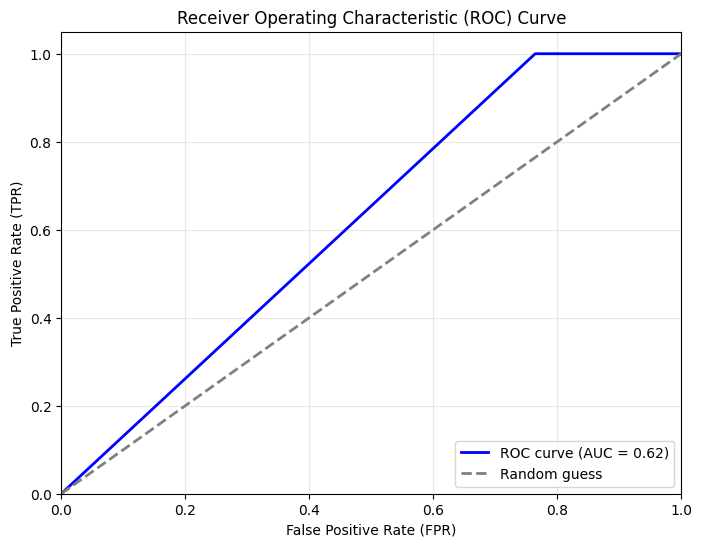

embedding:
auroc:  0.5673148840688107
auprc:  0.050600482870447286
fpr_at_tpr95:  0.824607329842932
thr_at_tpr95:  0.29690796521583906
Best F1: 0.11428571425371428
Threshold at best F1: 0.7835134512314128


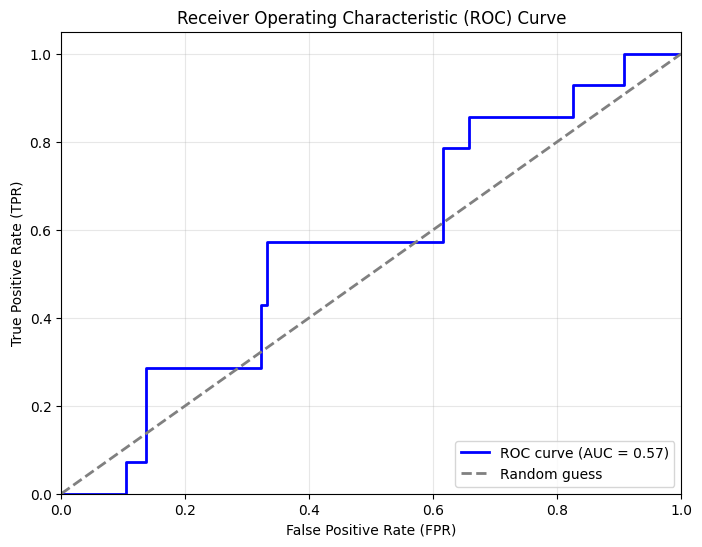

logprob:
auroc:  0.7819371727748691
auprc:  0.31267216362814676
fpr_at_tpr95:  0.4895287958115183
thr_at_tpr95:  8.969231794069808e-09
Best F1: 0.5185185184691359
Threshold at best F1: 0.9314054398036026


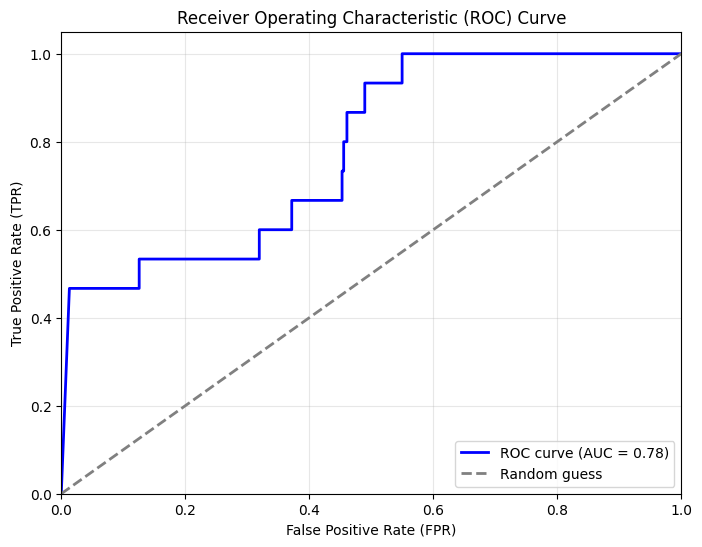

logprob_dif_llm:
auroc:  0.88717277486911
auprc:  0.45161022340656215
fpr_at_tpr95:  0.5104712041884817
thr_at_tpr95:  0.2025381454148545
Best F1: 0.6486486486004382
Threshold at best F1: 0.9816181104671766


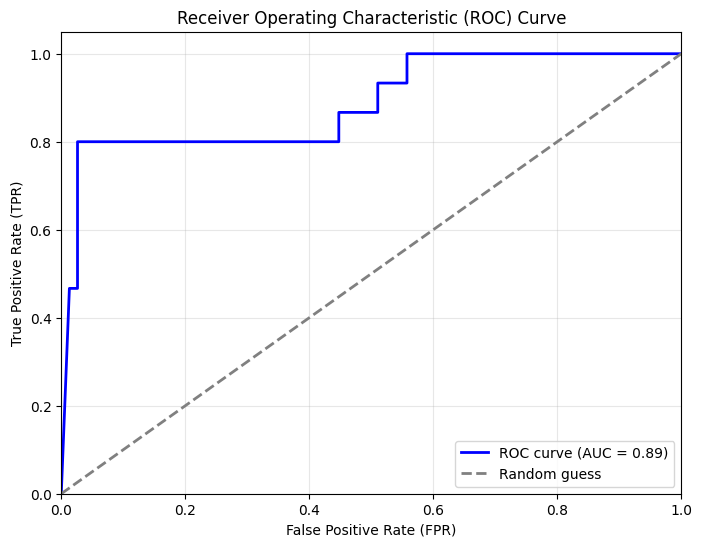

logprob_dif:
auroc:  0.7819371727748692
auprc:  0.31267216362814676
fpr_at_tpr95:  0.4895287958115183
thr_at_tpr95:  0.2000000050227697
Best F1: 0.5185185184691359
Threshold at best F1: 0.9314054398036026


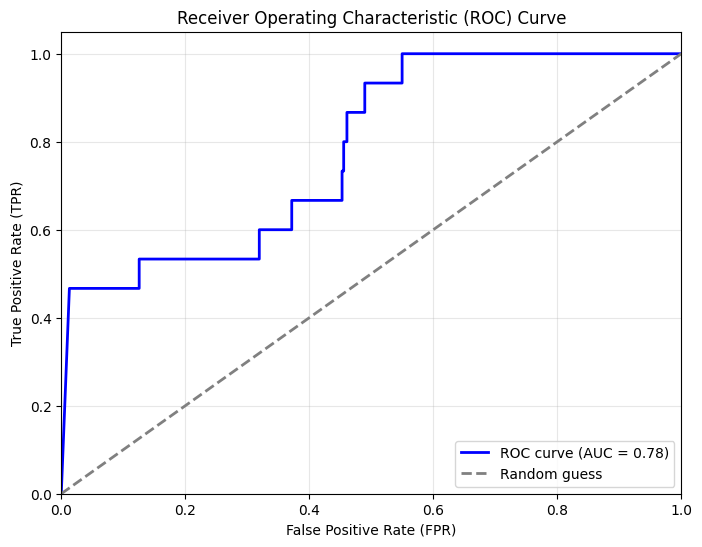

logprob_llm:
auroc:  0.8856020942408378
auprc:  0.4514207625966195
fpr_at_tpr95:  0.518324607329843
thr_at_tpr95:  0.0031726817685682196
Best F1: 0.6486486486004382
Threshold at best F1: 0.9770226380839708


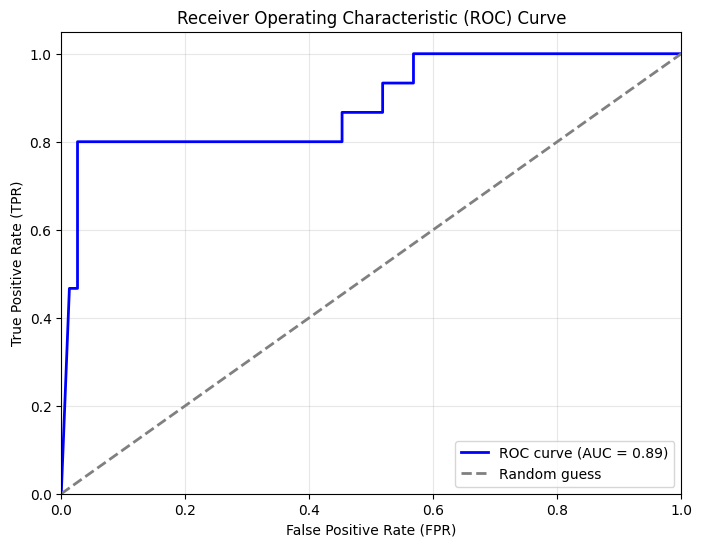

------
Task type: Unit
BM25:
auroc:  0.7455123410620792
auprc:  0.06819899677042533
fpr_at_tpr95:  0.4607329842931937
thr_at_tpr95:  0.9993532729934179
Best F1: 0.1280788177211483
Threshold at best F1: 0.9307609953063062


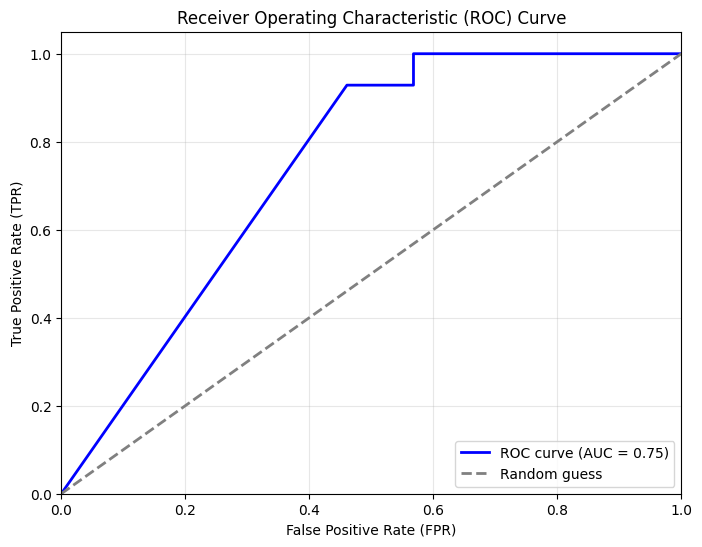

embedding:
auroc:  0.5418848167539267
auprc:  0.049144235463075184
fpr_at_tpr95:  0.9476439790575916
thr_at_tpr95:  0.5395176829593364
Best F1: 0.10869565214810963
Threshold at best F1: 0.8851611927948966


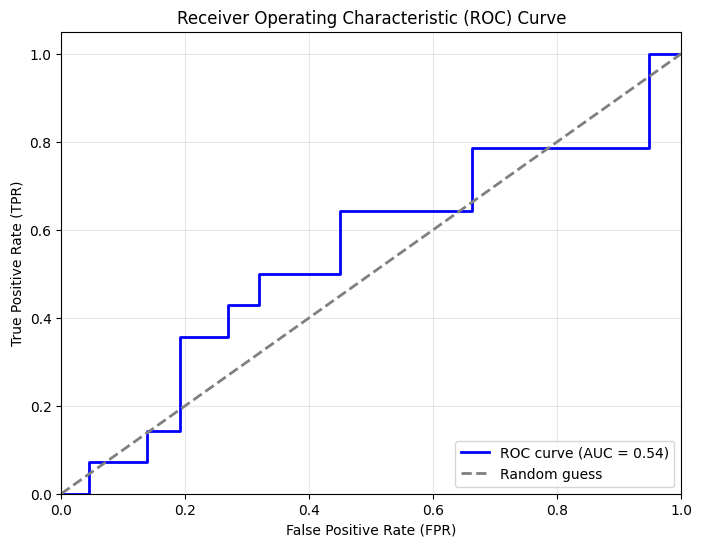

logprob:
auroc:  0.9054457292055204
auprc:  0.32012871812774196
fpr_at_tpr95:  0.26109660574412535
thr_at_tpr95:  0.000138644890700923
Best F1: 0.49999999995
Threshold at best F1: 0.8651177778228126


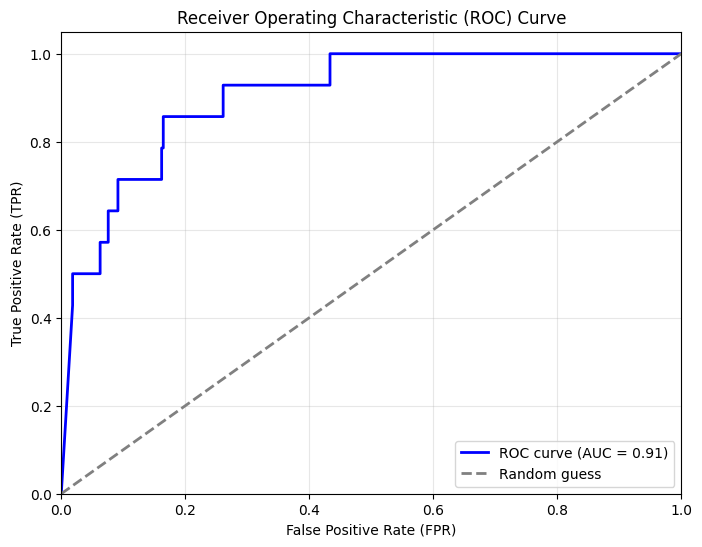

logprob_dif_llm:
auroc:  0.9045132413278627
auprc:  0.4036748788335137
fpr_at_tpr95:  0.5274151436031331
thr_at_tpr95:  0.20264870002471846
Best F1: 0.6153846153385929
Threshold at best F1: 0.9665372896892758


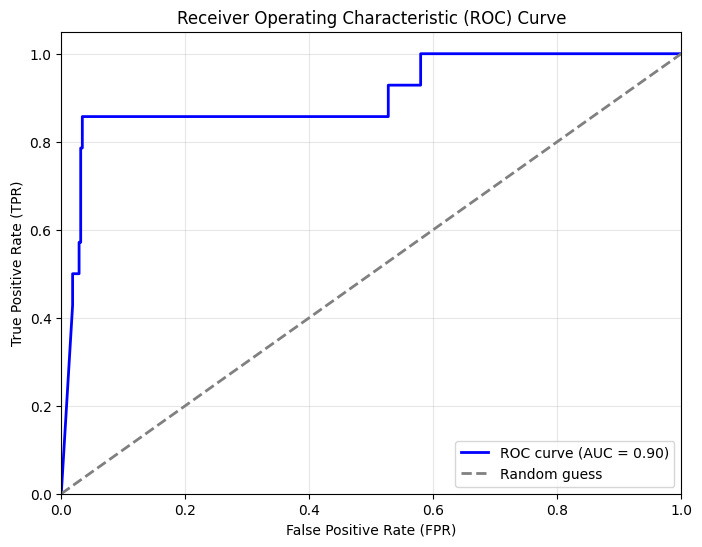

logprob_dif:
auroc:  0.9063782170831779
auprc:  0.32141335627678685
fpr_at_tpr95:  0.26109660574412535
thr_at_tpr95:  0.2001109159125607
Best F1: 0.49999999995
Threshold at best F1: 0.8651177778228126


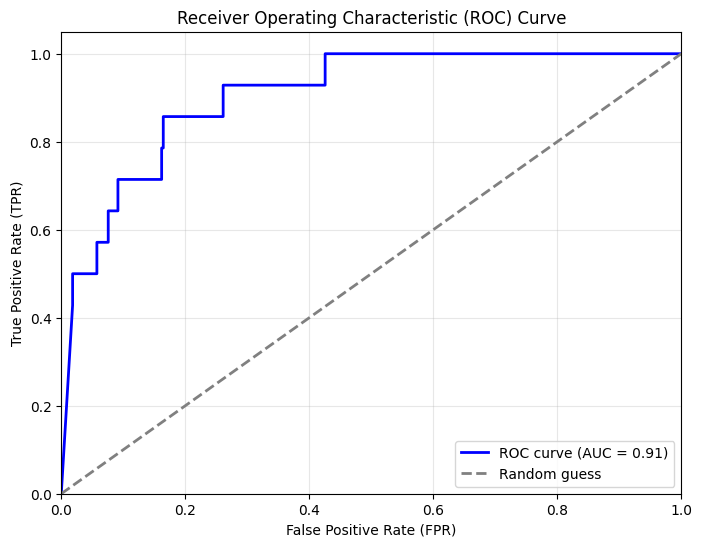

logprob_llm:
auroc:  0.9032077582991421
auprc:  0.40354482245343476
fpr_at_tpr95:  0.5352480417754569
thr_at_tpr95:  0.0033108750308981083
Best F1: 0.6153846153385929
Threshold at best F1: 0.9581716121115946


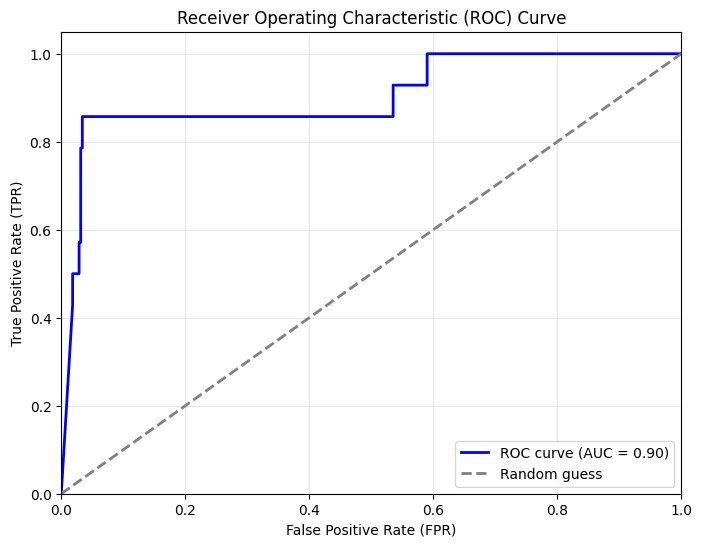

------
Task type: PrototypeData
BM25:
auroc:  0.5264531052475859
auprc:  0.6253174904540701
fpr_at_tpr95:  0.8104575163398693
thr_at_tpr95:  0.9307609959312335
Best F1: 0.7881773398535175
Threshold at best F1: 0.5867948601849363


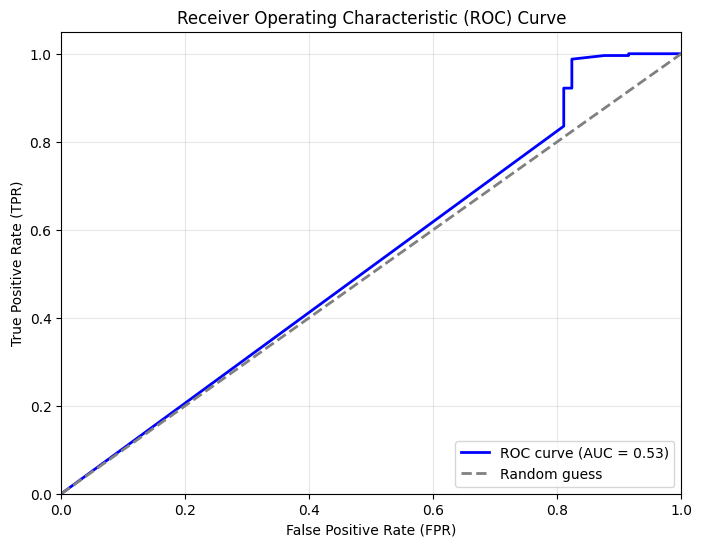

embedding:
auroc:  0.7136824551494123
auprc:  0.7991627123227008
fpr_at_tpr95:  0.8562091503267973
thr_at_tpr95:  0.16156186801927397
Best F1: 0.7812499999512208
Threshold at best F1: 0.3166740639765664


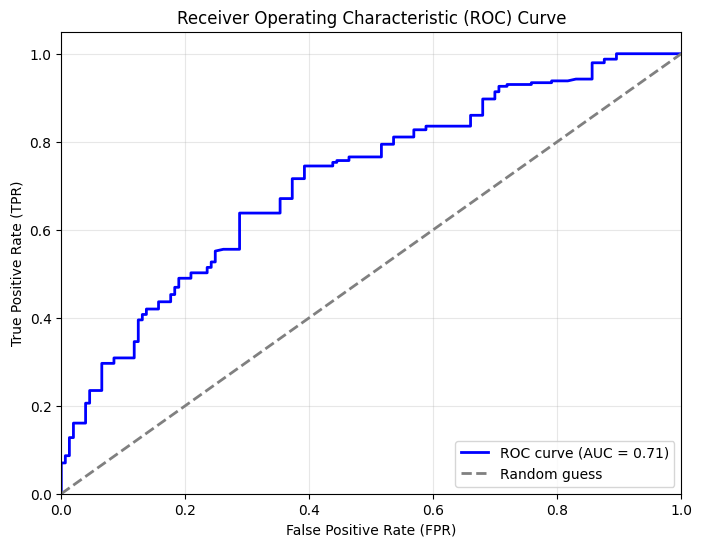

logprob:
auroc:  0.8952096613679766
auprc:  0.9198531443322269
fpr_at_tpr95:  0.5816993464052288
thr_at_tpr95:  3.552431204440571e-08
Best F1: 0.8752735229261314
Threshold at best F1: 0.053377240397724623


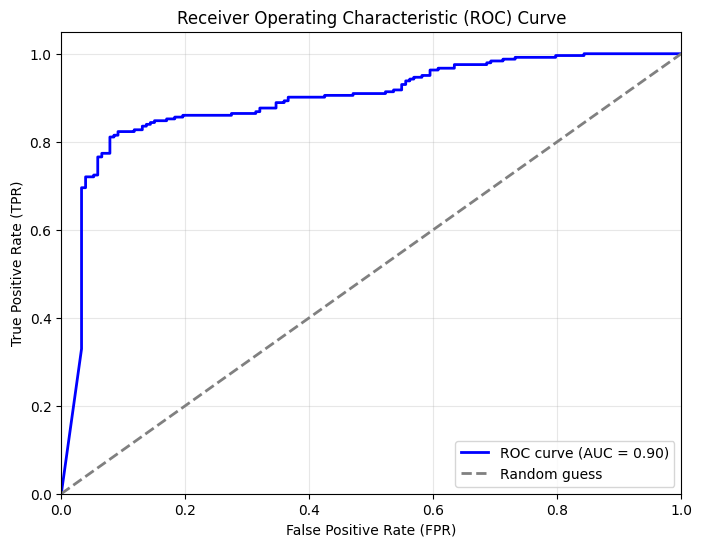

logprob_dif_llm:
auroc:  0.8853116006347671
auprc:  0.9189884842502017
fpr_at_tpr95:  0.7843137254901961
thr_at_tpr95:  0.20002843492683708
Best F1: 0.8978723403755899
Threshold at best F1: 0.2610176293292684


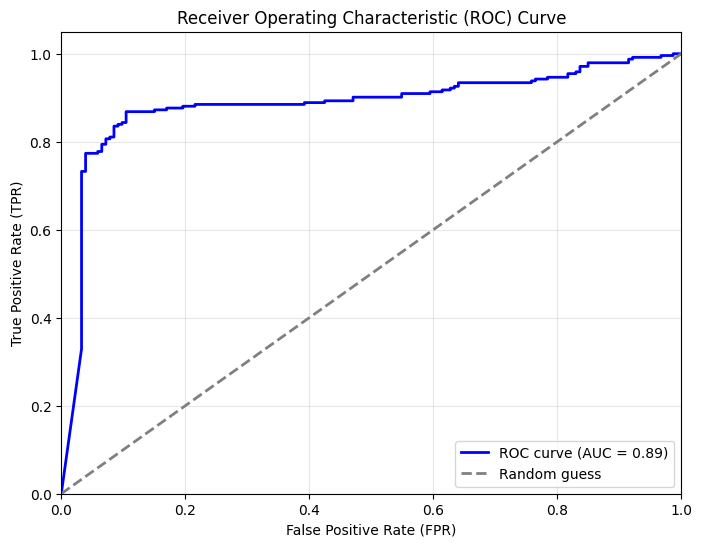

logprob_dif:
auroc:  0.8918475483471853
auprc:  0.9186261100920747
fpr_at_tpr95:  0.5555555555555556
thr_at_tpr95:  0.20000001546243462
Best F1: 0.8752735229261314
Threshold at best F1: 0.24270179231817968


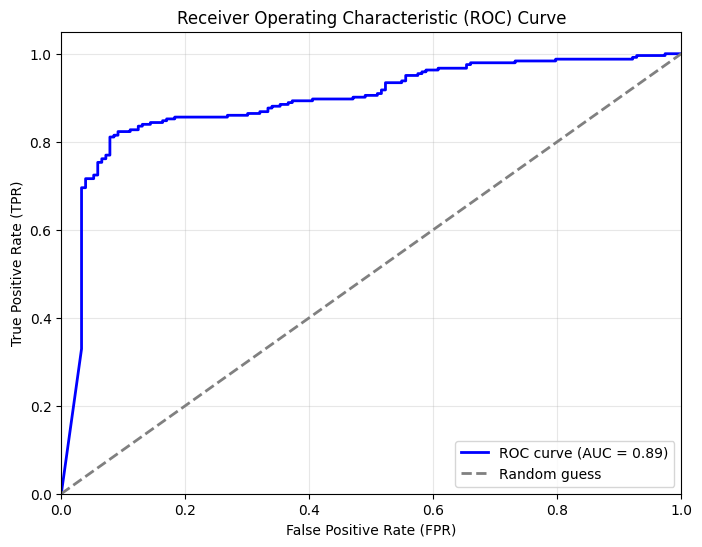

logprob_llm:
auroc:  0.8846391780306087
auprc:  0.919090031760986
fpr_at_tpr95:  0.8300653594771242
thr_at_tpr95:  5.836353825716678e-05
Best F1: 0.9002123141751037
Threshold at best F1: 0.07627203666158555


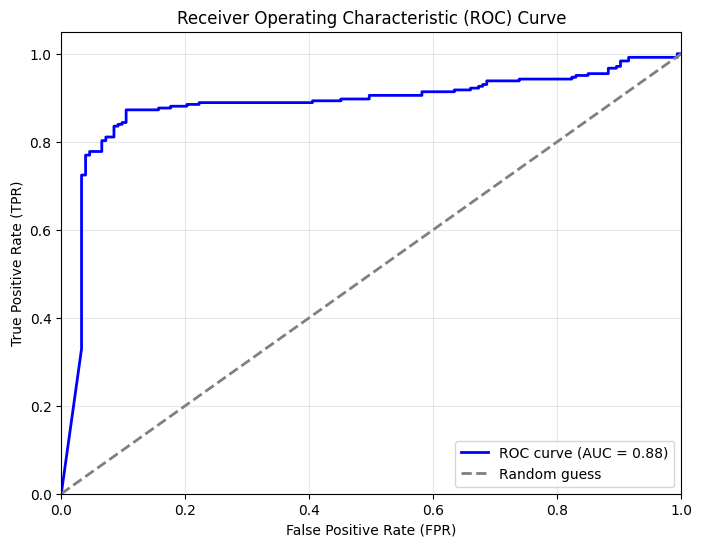

------


In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt


def calculate_nonID_metrics(
    result_labels: dict,
    nonid_labels: list = [
        "out-of-set",
        "uncertain",
        "OutOfSetUnit",
        "UncertainUnit",
        "OutOfSetQuantity",
        "UncertainQuantity",
        "UncertainPrototypeData",
        "OutOfSetPrototypeData",
        "None",
        "oos",
    ],
):
    nonid_labels = [lbl.lower() for lbl in nonid_labels]
    kickout_true_labels = [lbl.lower() for lbl in ["rejected"]]
    # y_true:  0=ID, 1=non-ID
    # nonid_score: higer means more alike non-ID
    y_true, nonid_score = [], []
    for i in range(len(result_labels["true"])):
        y = result_labels["true"][i]
        if any(label.lower() in kickout_true_labels for label in y):
            continue
        if any(label.lower() in nonid_labels for label in y):
            y_true.append(1)
        else:
            y_true.append(0)

        if "conf" in result_labels:
            nonid_score.append(result_labels["conf"][i])

        if any(label.lower() in nonid_labels for label in result_labels["pred"][i]) and result_labels["conf"][i] <= 0.5:
            print(f"{i}: true:{result_labels['true'][i]} pred:{result_labels['pred'][i]} conf:{result_labels['conf'][i]}")
            raise ValueError("nonid_score is wrong")

    # for i in range(len(y_true)):
    #     print(y_true[i], id_score[i])
    auroc = roc_auc_score(y_true, nonid_score)
    auprc = average_precision_score(y_true, nonid_score)

    # FPR@TPR95（positive=non-ID）
    fpr, tpr, thresh = roc_curve(y_true, nonid_score)  # tpr corresponds to the recall (Recall of non-ID), fpr is the rate of mistakenly accepting Unknown
    target = 0.95
    # Find the closest tpr point to 0.95
    idx = np.argmin(np.abs(tpr - target))
    fpr_at_tpr95 = fpr[idx]
    thr_at_tpr95 = thresh[idx]

    # simplest way (direct from y_true and y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, nonid_score)

    # compute F1 at each threshold
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    best_index = f1.argmax()
    best_f1 = f1[best_index]
    best_threshold = thresholds[max(best_index - 1, 0)] if len(thresholds) else None

    print("auroc: ", auroc)
    print("auprc: ", auprc)
    print("fpr_at_tpr95: ", fpr_at_tpr95)
    print("thr_at_tpr95: ", thr_at_tpr95)
    print("Best F1:", best_f1)
    print("Threshold at best F1:", best_threshold)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {auroc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--", label="Random guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


# return auroc, auprc, fpr_at_tpr95, thr_at_tpr95


for t in ["Quantity", "Unit", "PrototypeData"]:
    print("Task type:", t)
    print("BM25:")
    calculate_nonID_metrics(merged_labels_BM25[t])
    print("embedding:")
    calculate_nonID_metrics(merged_labels_embedding[t])
    print("logprob:")
    calculate_nonID_metrics(merged_labels_logprob[t])
    print("logprob_dif_llm:")
    calculate_nonID_metrics(merged_labels_logprob_dif_llm[t])
    print("logprob_dif:")
    calculate_nonID_metrics(merged_labels_logprob_dif[t])
    print("logprob_llm:")
    calculate_nonID_metrics(merged_labels_logprob_llm[t])
    print("------")

## F1 score calculation


In [6]:
import os
from sklearn.metrics import (
    confusion_matrix,
    # precision_score,
    # recall_score,
    f1_score,
    classification_report,
    # ConfusionMatrixDisplay,
    # multilabel_confusion_matrix,
)

# from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd  # noqa


def calc_confusion_matrix_and_metrics(
    data: dict,
    kickout_true_labels: list = [
        "None",
        "out-of-set",
        "uncertain",
        "rejected",
        "OutOfSetUnit",
        "UncertainUnit",
        "OutOfSetQuantity",
        "UncertainQuantity",
        "UncertainPrototypeData",
        "OutOfSetPrototypeData",
        "oos",
    ],
):
    # Extract the true labels and the predicted labels from the input data
    y_true_raw = data["true"]
    y_pred_raw = data["pred"]

    kickout_true_labels = [lbl.lower() for lbl in kickout_true_labels]

    y_true, y_pred = [], []
    for i in range(len(y_true_raw)):
        # The ID performance only accounts in ID samples.
        if any(label.lower() in kickout_true_labels for label in y_true_raw[i]):
            continue

        label_pred = y_pred_raw[i][0]
        y_pred.append(label_pred)
        if label_pred in y_true_raw[i]:
            y_true.append(label_pred)
        else:
            y_true.append(y_true_raw[i][0])

    # Get the unique labels from the combined list of true and predicted labels
    # labels = np.unique(y_true + y_pred)
    labels = np.unique(y_true)

    # Calculate the confusion matrix using the unique labels to ensure proper order
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Convert the confusion matrix to a pandas DataFrame with row and column headers
    cm_df = pd.DataFrame(cm, index=[f"Actual: {label}" for label in labels], columns=[f"Predicted: {label}" for label in labels])
    print("Confusion Matrix with Headers:\n", cm_df, "\n")

    # Calculate TP, FP, FN, TN for each class:
    # - True Positives (TP): correctly predicted for the class (diagonal of confusion matrix)
    # - False Positives (FP): predicted as the class but actually not that class
    # - False Negatives (FN): actual class but predicted as another class
    # - True Negatives (TN): all other correct predictions not related to this class
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    # Print the metrics for each class
    for i, label in enumerate(labels):
        print(f"Label '{label}':\tTP={tp[i]}, FP={fp[i]}, FN={fn[i]}, TN={tn[i]}")

    f1_micro = f1_score(y_true, y_pred, labels=labels, average="micro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)
    class_report = classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0, output_dict=True)

    return {
        "confusion_matrices": cm,
        "classes": labels,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "report": class_report,
    }


def _to_serializable(obj):
    """For json.dump()."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.bool_,)):
        return bool(obj)
    return obj


In [7]:
result_BM25_merged, result_embedding_merged, result_logprob_merged, result_simpleRAG_merged = {}, {}, {}, {}
for task in ["Quantity", "Unit", "PrototypeData"]:
    result_BM25_merged.update({task: calc_confusion_matrix_and_metrics(merged_labels_BM25[task])})
    result_embedding_merged.update({task: calc_confusion_matrix_and_metrics(merged_labels_embedding[task])})
    result_logprob_merged.update({task: calc_confusion_matrix_and_metrics(merged_labels_logprob[task])})
    result_simpleRAG_merged.update({task: calc_confusion_matrix_and_metrics(merged_labels_simpleRAG[task])})

evaluation_path = project_root / "notebooks/evaluation"
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
with open(evaluation_path / "result_BM25_merged.json", "w", encoding="utf-8") as f:
    json.dump(result_BM25_merged, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_embedding_merged.json", "w", encoding="utf-8") as f:
    json.dump(result_embedding_merged, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_logprob_merged.json", "w", encoding="utf-8") as f:
    json.dump(result_logprob_merged, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_simpleRAG_merged.json", "w", encoding="utf-8") as f:
    json.dump(result_simpleRAG_merged, f, ensure_ascii=False, indent=4, default=_to_serializable)

with pd.ExcelWriter(evaluation_path / "classification_report_BM25.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_BM25_merged["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_BM25_merged["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_BM25_merged["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")


with pd.ExcelWriter(evaluation_path / "classification_report_embedding.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_embedding_merged["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_embedding_merged["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_embedding_merged["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")

with pd.ExcelWriter(evaluation_path / "classification_report_logprob.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_logprob_merged["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_logprob_merged["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_logprob_merged["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")

with pd.ExcelWriter(evaluation_path / "classification_report_simpleRAG.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_simpleRAG_merged["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_simpleRAG_merged["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_simpleRAG_merged["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")

Confusion Matrix with Headers:
                                      Predicted: AccelerationQuantity  \
Actual: AccelerationQuantity                                       0   
Actual: ConcentrationQuantity                                      0   
Actual: DimensionlessQuantity                                      0   
Actual: ElectricResistivityQuantity                                0   
Actual: ForceQuantity                                              0   
Actual: FrequencyQuantity                                          0   
Actual: LengthQuantity                                             0   
Actual: MassDensityQuantity                                        0   
Actual: PlaneAngleQuantity                                         0   
Actual: PressureQuantity                                           0   
Actual: ProportionQuantity                                         0   
Actual: TemperatureQuantity                                        0   
Actual: TimeQuantity            

Simple RAG can not produce matching score. So, only the macro F1 for non-ID vs ID classification is computed here.


In [8]:
def calc_confusion_matrix_and_metrics_nonid(data: dict, selected_classes: list = ["out-of-set", "uncertain"]):
    nonid_labels = [
        "None",
        "out-of-set",
        "uncertain",
        "OutOfSetUnit",
        "UncertainUnit",
        "OutOfSetQuantity",
        "UncertainQuantity",
        "UncertainPrototypeData",
        "OutOfSetPrototypeData",
        "oos",
    ]

    nonid_labels = [lbl.lower() for lbl in set(nonid_labels + selected_classes)]
    kickout_true_labels = [lbl.lower() for lbl in ["rejected"]]

    # Extract the true labels and the predicted labels from the input data
    y_true_raw = data["true"]
    y_pred_raw = data["pred"]

    y_true, y_pred = [], []
    for i in range(len(y_true_raw)):
        # Filter out "rejected"(filtered) samples
        if any(label.lower() in kickout_true_labels for label in y_true_raw[i]):
            continue

        # The non-ID performance accounts in both non-ID and ID samples.
        # Convert the multi-class classification results to binary classification
        if any(label.lower() in nonid_labels for label in y_true_raw[i]):
            y_true.append("non-ID")
        else:
            y_true.append("ID")

        label_pred = y_pred_raw[i][0]
        if label_pred.lower() in nonid_labels:
            # if label_pred in nonid_labels and any(label in selected_classes for label in y_true_raw[i]):
            # If a prediction on a non-ID sample is correct, align the predication lable to "non-ID"
            y_pred.append("non-ID")
        else:
            # Otherwise, align to "ID"
            y_pred.append("ID")

    # Get the unique labels from the combined list of true and predicted labels
    # labels = np.unique(y_true + y_pred)
    labels = np.unique(y_true)

    # Calculate the confusion matrix using the unique labels to ensure proper order
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Convert the confusion matrix to a pandas DataFrame with row and column headers
    cm_df = pd.DataFrame(cm, index=[f"Actual: {label}" for label in labels], columns=[f"Predicted: {label}" for label in labels])
    print("Confusion Matrix with Headers:\n", cm_df, "\n")

    # Calculate TP, FP, FN, TN for each class:
    # - True Positives (TP): correctly predicted for the class (diagonal of confusion matrix)
    # - False Positives (FP): predicted as the class but actually not that class
    # - False Negatives (FN): actual class but predicted as another class
    # - True Negatives (TN): all other correct predictions not related to this class
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    # Print the metrics for each class
    for i, label in enumerate(labels):
        print(f"Label '{label}':\tTP={tp[i]}, FP={fp[i]}, FN={fn[i]}, TN={tn[i]}")

    f1_micro = f1_score(y_true, y_pred, labels=labels, average="micro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)
    class_report = classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0, output_dict=True)

    return {
        "confusion_matrices": cm,
        "classes": labels,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "report": class_report,
    }


# Only compute F1 for Non-ID samples.
result_BM25_merged_nonid, result_embedding_merged_nonid, result_logprob_merged_nonid, result_simpleRAG_merged_nonid = {}, {}, {}, {}
for task in ["Quantity", "Unit", "PrototypeData"]:
    result_BM25_merged_nonid.update({task: calc_confusion_matrix_and_metrics_nonid(merged_labels_BM25[task])})
    result_embedding_merged_nonid.update({task: calc_confusion_matrix_and_metrics_nonid(merged_labels_embedding[task])})
    result_logprob_merged_nonid.update({task: calc_confusion_matrix_and_metrics_nonid(merged_labels_logprob[task])})
    result_simpleRAG_merged_nonid.update({task: calc_confusion_matrix_and_metrics_nonid(merged_labels_simpleRAG[task])})

evaluation_path = project_root / "notebooks/evaluation"
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
with open(evaluation_path / "result_BM25_merged_nonid.json", "w", encoding="utf-8") as f:
    json.dump(result_BM25_merged_nonid, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_embedding_merged_nonid.json", "w", encoding="utf-8") as f:
    json.dump(result_embedding_merged_nonid, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_logprob_merged_nonid.json", "w", encoding="utf-8") as f:
    json.dump(result_logprob_merged_nonid, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_simpleRAG_merged_nonid.json", "w", encoding="utf-8") as f:
    json.dump(result_simpleRAG_merged_nonid, f, ensure_ascii=False, indent=4, default=_to_serializable)

with pd.ExcelWriter(evaluation_path / "classification_report_BM25_nonid.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_BM25_merged_nonid["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_BM25_merged_nonid["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_BM25_merged_nonid["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")

with pd.ExcelWriter(evaluation_path / "classification_report_embedding_nonid.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_embedding_merged_nonid["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_embedding_merged_nonid["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_embedding_merged_nonid["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")

with pd.ExcelWriter(evaluation_path / "classification_report_logprob_nonid.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_logprob_merged_nonid["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_logprob_merged_nonid["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_logprob_merged_nonid["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")

with pd.ExcelWriter(evaluation_path / "classification_report_simpleRAG_nonid.xlsx") as writer:
    cr_pd_df = pd.DataFrame(result_simpleRAG_merged_nonid["PrototypeData"]["report"]).transpose()
    cr_pd_df.to_excel(writer, index=True, sheet_name="PrototypeData")
    cr_un_df = pd.DataFrame(result_simpleRAG_merged_nonid["Unit"]["report"]).transpose()
    cr_un_df.to_excel(writer, index=True, sheet_name="Unit")
    cr_qu_df = pd.DataFrame(result_simpleRAG_merged_nonid["Quantity"]["report"]).transpose()
    cr_qu_df.to_excel(writer, index=True, sheet_name="Quantity")

Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                382                  0
Actual: non-ID             14                  0 

Label 'ID':	TP=382, FP=14, FN=0, TN=0
Label 'non-ID':	TP=0, FP=0, FN=14, TN=382
Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                382                  0
Actual: non-ID             14                  0 

Label 'ID':	TP=382, FP=14, FN=0, TN=0
Label 'non-ID':	TP=0, FP=0, FN=14, TN=382
Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                371                 11
Actual: non-ID              8                  7 

Label 'ID':	TP=371, FP=8, FN=11, TN=7
Label 'non-ID':	TP=7, FP=11, FN=8, TN=371
Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                376                  6
Actual: non-ID              8                  7 

Label 'ID':	TP=376, FP=8, FN=6, TN=7

## Same evaluation on public dataset CLINC

Evaluate the non-ID and ID classification performace using a public dataset [clinc_oos](https://huggingface.co/datasets/clinc/clinc_oos).
For simplication purpose, only test on the small/validation set, which including 3100 samples.


### ID vs Non-ID metrics


auroc:  0.5
auprc:  0.25
fpr_at_tpr95:  1.0
thr_at_tpr95:  0.999353272993418
Best F1: 0.399999999968
Threshold at best F1: 0.999353272993418


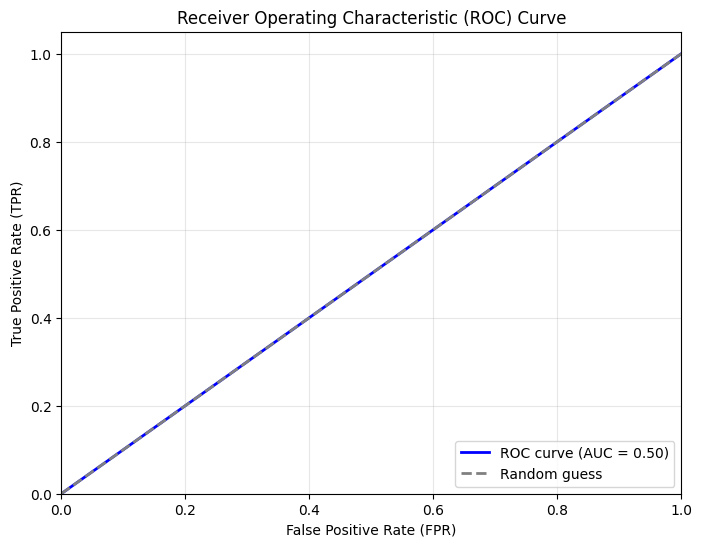

auroc:  0.8864
auprc:  0.6429027404205685
fpr_at_tpr95:  0.31333333333333335
thr_at_tpr95:  0.9676793520734822
Best F1: 0.706827309188884
Threshold at best F1: 0.972790741854789


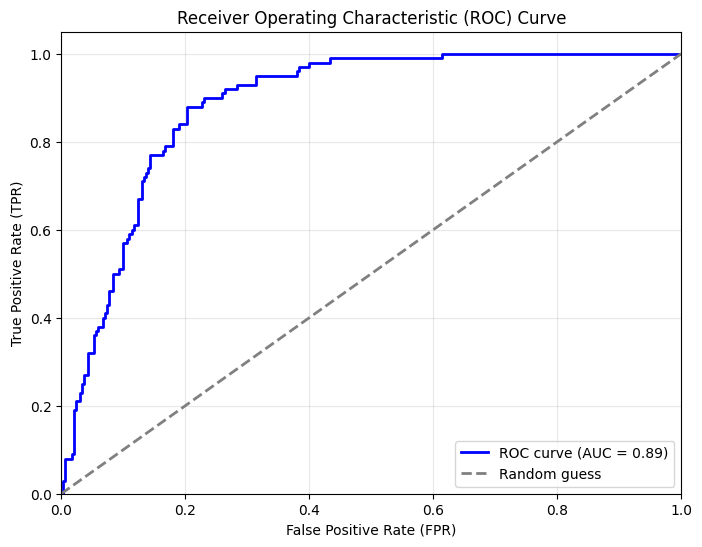

In [9]:
result_clinc_bm25_path = project_root / "notebooks/BM25/recognition_results_clinc.json"
result_clinc_embedding_path = project_root / "notebooks/Embedding/recognition_results_clinc.json"
result_clinc_simpleRAG_path = project_root / "notebooks/simpleRAG/recognition_results_clinc.json"
result_clinc_logprob_path = project_root / "notebooks/logprob/recognition_results_clinc.json"
with open(result_clinc_bm25_path, "r", encoding="utf-8") as f:
    result_clinc_bm25 = json.load(f)
with open(result_clinc_embedding_path, "r", encoding="utf-8") as f:
    result_clinc_embedding = json.load(f)
with open(result_clinc_simpleRAG_path, "r", encoding="utf-8") as f:
    result_clinc_simpleRAG = json.load(f)
with open(result_clinc_logprob_path, "r", encoding="utf-8") as f:
    result_clinc_logprob = json.load(f)

result_labels_clinc_bm25 = {"true": [], "pred": [], "conf": []}
result_labels_clinc_embedding = {"true": [], "pred": [], "conf": []}
result_labels_clinc_simpleRAG = {"true": [], "pred": [], "conf": []}
result_labels_clinc_logprob = {"true": [], "pred": [], "conf": []}


def convert_to_true_pred_conf(data: dict, hasMatchingScore: bool = True) -> dict:
    result = {"true": [], "pred": [], "conf": []}
    for text, info in data.items():
        # true label
        result["true"].append([info["true_label"]])
        if hasMatchingScore:
            # top-1 candidate by score
            candidates = info["candidates"]
            top_pred = max(candidates.items(), key=lambda x: x[1])[0]
            result["pred"].append([top_pred])
            # placeholder confidence
            nonid_score = qg.compute_nonid_score(candidates, True)
            # top_pred = max(candidates.items(), key=lambda x: x[1])[0]
            # nonid_score = qg.simulate_nonid_score(top_pred)
            result["conf"].append(nonid_score)
        else:
            result["pred"].append([info["candidates"]])
    return result


result_labels_clinc_bm25 = convert_to_true_pred_conf(result_clinc_bm25)
result_labels_clinc_embedding = convert_to_true_pred_conf(result_clinc_embedding)
result_labels_clinc_simpleRAG = convert_to_true_pred_conf(result_clinc_simpleRAG, False)
result_labels_clinc_logprob = convert_to_true_pred_conf(result_clinc_logprob)


calculate_nonID_metrics(result_labels_clinc_bm25, ["oos"])
calculate_nonID_metrics(result_labels_clinc_embedding, ["oos"])
# calculate_nonID_metrics(result_labels_clinc_simpleRAG, ["oos"])
# calculate_nonID_metrics(result_labels_clinc_logprob, ["oos"])

### F1 score

Compute F1 for ID samples.


In [10]:
result_BM25_clinc = calc_confusion_matrix_and_metrics(result_labels_clinc_bm25, ["oos"])
result_embedding_clinc = calc_confusion_matrix_and_metrics(result_labels_clinc_embedding, ["oos"])
result_simpleRAG_clinc = calc_confusion_matrix_and_metrics(result_labels_clinc_simpleRAG, ["oos"])
result_logprob_clinc = calc_confusion_matrix_and_metrics(result_labels_clinc_logprob, ["oos"])

evaluation_path = project_root / "notebooks/evaluation"
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
with open(evaluation_path / "result_BM25_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_BM25_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_embedding_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_embedding_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_simpleRAG_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_simpleRAG_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_logprob_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_logprob_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)


with pd.ExcelWriter(evaluation_path / "classification_report_BM25_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_BM25_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_ID")

with pd.ExcelWriter(evaluation_path / "classification_report_embedding_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_embedding_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_ID")

with pd.ExcelWriter(evaluation_path / "classification_report_logprob_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_logprob_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_ID")

with pd.ExcelWriter(evaluation_path / "classification_report_simpleRAG_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_simpleRAG_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_ID")


Confusion Matrix with Headers:
                                 Predicted: accept_reservations  \
Actual: accept_reservations                                  0   
Actual: account_blocked                                      0   
Actual: bill_balance                                         0   
Actual: change_language                                      0   
Actual: freeze_account                                       0   
Actual: gas_type                                             0   
Actual: improve_credit_score                                 0   
Actual: interest_rate                                        0   
Actual: jump_start                                           0   
Actual: make_call                                            0   
Actual: meaning_of_life                                      0   
Actual: meeting_schedule                                     0   
Actual: nutrition_info                                       0   
Actual: oil_change_how                      

Compute F1 for only Non-ID samples.


In [11]:
result_BM25_nonid_clinc = calc_confusion_matrix_and_metrics_nonid(result_labels_clinc_bm25, ["oos"])
result_embedding_nonid_clinc = calc_confusion_matrix_and_metrics_nonid(result_labels_clinc_embedding, ["oos"])
result_logprob_nonid_clinc = calc_confusion_matrix_and_metrics_nonid(result_labels_clinc_simpleRAG, ["oos"])
result_simpleRAG_nonid_clinc = calc_confusion_matrix_and_metrics_nonid(result_labels_clinc_logprob, ["oos"])

evaluation_path = project_root / "notebooks/evaluation"
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
with open(evaluation_path / "result_BM25_nonid_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_BM25_nonid_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_embedding_nonid_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_embedding_nonid_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_logprob_nonid_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_logprob_nonid_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)
with open(evaluation_path / "result_simpleRAG_nonid_clinc.json", "w", encoding="utf-8") as f:
    json.dump(result_simpleRAG_nonid_clinc, f, ensure_ascii=False, indent=4, default=_to_serializable)

with pd.ExcelWriter(evaluation_path / "classification_report_BM25_nonid_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_BM25_nonid_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_NonID")

with pd.ExcelWriter(evaluation_path / "classification_report_embedding_nonid_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_embedding_nonid_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_NonID")

with pd.ExcelWriter(evaluation_path / "classification_report_logprob_nonid_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_logprob_nonid_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_NonID")

with pd.ExcelWriter(evaluation_path / "classification_report_simpleRAG_nonid_clinc.xlsx") as writer:
    cr_df = pd.DataFrame(result_simpleRAG_nonid_clinc["report"]).transpose()
    cr_df.to_excel(writer, index=True, sheet_name="CLINC_NonID")


Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                300                  0
Actual: non-ID            100                  0 

Label 'ID':	TP=300, FP=100, FN=0, TN=0
Label 'non-ID':	TP=0, FP=0, FN=100, TN=300
Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                298                  2
Actual: non-ID             99                  1 

Label 'ID':	TP=298, FP=99, FN=2, TN=1
Label 'non-ID':	TP=1, FP=2, FN=99, TN=298
Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                292                  8
Actual: non-ID             15                 85 

Label 'ID':	TP=292, FP=15, FN=8, TN=85
Label 'non-ID':	TP=85, FP=8, FN=15, TN=292
Confusion Matrix with Headers:
                 Predicted: ID  Predicted: non-ID
Actual: ID                298                  2
Actual: non-ID             14                 86 

Label 'ID':	TP=298, FP=14, FN=2,